# **Main Modeling : -**

In [ ]:
import warnings
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 600)
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

import re
import string

import gensim
from gensim import models, corpora, similarities
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
import random
import collections

<ipython-input-1-503e73b49df8>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/My Drive/Design Project"

/content/drive/My Drive/Design Project


In [ ]:
train_data = pd.read_csv('preprocessed_train_data.csv')
test_data = pd.read_csv('preprocessed_test_data.csv')
valid_data = pd.read_csv('preprocessed_valid_data.csv')

## **Logistic Regression**

### **1.BOW**

In [ ]:
# Select the features and the target
X = train_data["text_preprocessed"]
y = train_data["propaganda_label"]

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)

In [ ]:
# Set an bog of words object
text_ext_bow = CountVectorizer(analyzer='word',
                                ngram_range=(1, 3),
                                stop_words="english",
                                min_df = 100,
                                max_df = 0.90)

In [ ]:
# Fitting the vectorizer with our training set

bow_train = text_ext_bow.fit_transform(X_train)

In [ ]:
# Now we can fit our test data with the same vectorizer

bow_test = text_ext_bow.transform(X_test)

In [ ]:
# Logistic regression without class weight

logistic_regression = LogisticRegression(random_state = 50)
logistic_regression.fit(bow_train, y_train)

# Predict on test data
predictions = logistic_regression.predict(bow_test)


# Print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.97      0.98      0.97      6394
           1       0.79      0.72      0.75       804

    accuracy                           0.95      7198
   macro avg       0.88      0.85      0.86      7198
weighted avg       0.95      0.95      0.95      7198



**Observations:**

- F1-score for the negative **class (-1) is high at 0.97**, indicating good precision and recall for identifying non-propagandistic articles.

- F1-score for the positive **class (1) is lower at 0.75**, suggesting lower precision and recall for identifying propagandistic articles.

- The overall accuracy is **0.95**, which is relatively high, but it may not be the best metric to evaluate due to class imbalance.

- The model has a higher performance for the majority class (non-propagandistic) and a relatively lower performance for the minority class (propagandistic).

**While the model performs well for non-propagandistic articles, it may require further tuning or handling of class imbalance to improve performance on propagandistic articles.**

In [ ]:
# checking for distribution of labels

y.value_counts(normalize=True)

-1    0.888262
 1    0.111738
Name: propaganda_label, dtype: float64

In [ ]:
# Logistic regression with class weight

logistic_regression = LogisticRegression(class_weight={-1:0.2, 1:0.8}, random_state = 50)
logistic_regression.fit(bow_train, y_train)

# Predict on test data
predictions = logistic_regression.predict(bow_test)


# Print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.97      0.97      0.97      6394
           1       0.77      0.74      0.76       804

    accuracy                           0.95      7198
   macro avg       0.87      0.86      0.86      7198
weighted avg       0.95      0.95      0.95      7198



**Observations:**

- F1-score for the negative **class (-1) is high at 0.97**, indicating good precision and recall for identifying non-propagandistic articles.

- F1-score for the positive **class (1) is lower at 0.76**, suggesting lower precision and recall for identifying propagandistic articles.

- The overall accuracy is **0.95**, which is relatively high, but it may not be the best metric to evaluate due to class imbalance.

- The model has a higher performance for the majority class (non-propagandistic) and a relatively lower performance for the minority class (propagandistic).

**While the model performs well for non-propagandistic articles, it may require further tuning or handling of class imbalance to improve performance on propagandistic articles.**

In [ ]:
%%time

# Hyperparameter tuning

# Creating model instance
lr = LogisticRegression(random_state = 50)

# Setting the range for class weights
weights = np.linspace(0.0, 0.99, 10)

# specifying all hyperparameters with possible values
param= {'C': [0.1, 0.5, 1, 10, 15, 20], 'penalty': ['l1', 'l2'], "class_weight":[{-1:x , 1:1.0 -x} for x in weights]}

# Create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 50)

# Hyperparameter tuning using Gridsearch
model= GridSearchCV(estimator= lr, param_grid=param, scoring="f1", cv=folds, return_train_score=True)

#train model to learn relationships between x and y
model.fit(bow_train, y_train)

CPU times: user 16min 11s, sys: 18min 21s, total: 34min 33s
Wall time: 21min 54s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=50, shuffle=True),
             estimator=LogisticRegression(random_state=50),
             param_grid={'C': [0.1, 0.5, 1, 10, 15, 20],
                         'class_weight': [{-1: 0.0, 1: 1.0},
                                          {-1: 0.11, 1: 0.89},
                                          {-1: 0.22, 1: 0.78},
                                          {-1: 0.33, 1: 0.6699999999999999},
                                          {-1: 0.44, 1: 0.56},
                                          {-1: 0.55, 1: 0.44999999999999996},
                                          {-1: 0.66, 1: 0.33999999999999997},
                                          {-1: 0.77, 1: 0.22999999999999998},
                                          {-1: 0.88, 1: 0.12},
                                          {-1: 0.99, 1: 0.010000000000000009}],
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1')

In [ ]:
# printing best hyperparameters

print("Best F1 score: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best F1 score:  0.7947490437156339
Best hyperparameters:  {'C': 0.1, 'class_weight': {-1: 0.22, 1: 0.78}, 'penalty': 'l2'}


In [ ]:
# Building model again with best params

lr_best = LogisticRegression(class_weight = {-1: 0.22, 1: 0.78}, C = 0.1, penalty = "l2", random_state = 50)

lr_best.fit(bow_train, y_train)

LogisticRegression(C=0.1, class_weight={-1: 0.22, 1: 0.78}, random_state=50)

In [ ]:
# Train data performance

# Predict on test data
predictions = lr_best.predict(bow_test)

# Print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.97      0.98      0.97      6394
           1       0.79      0.74      0.77       804

    accuracy                           0.95      7198
   macro avg       0.88      0.86      0.87      7198
weighted avg       0.95      0.95      0.95      7198



Confusion Matrix

[[6237  157]
 [ 208  596]]


Classification Report

              precision    recall  f1-score   support

          -1       0.97      0.98      0.97      6394
           1       0.79      0.74      0.77       804

    accuracy                           0.95      7198
   macro avg       0.88      0.86      0.87      7198
weighted avg       0.95      0.95      0.95      7198


ROC AUC Score: 0.8583696313552661


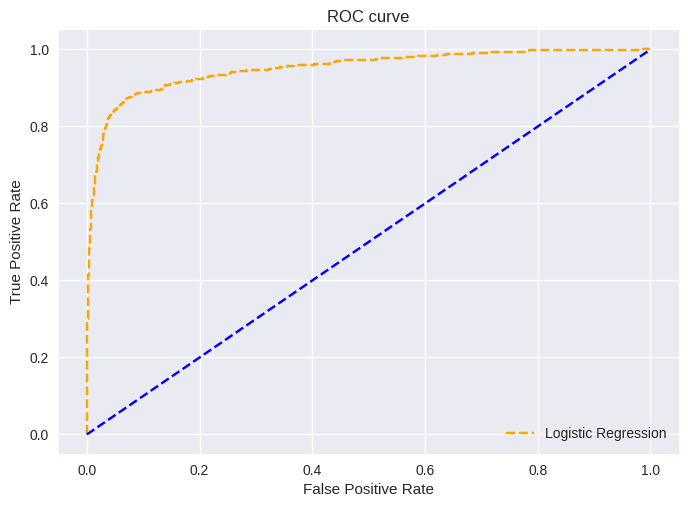

In [ ]:
# Evaluating the model on Training data

plt.style.use('seaborn')


# Predicting the labels for train data
y_pred = lr_best.predict(bow_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Get probabilities
y_pred_proba = lr_best.predict_proba(bow_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualize the ROC curve
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

**Observations:**
- Hyperparameter tuning has slightly improved the model's performance, particularly for the positive class (propagandistic).
- The ROC AUC score is 0.858, indicating good discrimination ability between the two classes and has a good balance between true positive rate and false positive rate.
- The model has achieved an overall accuracy of 0.95, consistent with previous results.

In [ ]:
# Checking validation data

valid_data.head()

,text_preprocessed,propaganda_label
0,"convened examine cause civil unrest black communities, presidential commission issued report stark conclusion: america moving towards two societies, ""one black, one white — separate unequal."" fifty year historic kerner commission identified ""white racism"" key cause ""pervasive discrimination employment, education housing,"" progress african american fare comparison white come homeownership, unemployment incarceration, according report economic policy institute released monday. cases, african american worse today civil right movement culminated law barring housing voter discrimination well ra...",-1
1,"discriminating someone basis sexual orientation prohibited federal civil right law, federal appeal court ruled monday sided gay skydiving instructor fired job discussing sexuality client. decision u.s. court appeal 2nd circuit offer expanded protection lgbt people mark significant loss president donald trump justice department, filed brief arguing title vii civil right act cover sexual orientation discrimination. state law still murky, federal circuit part country issued mixed opinions. ruling 2nd circuit, based manhattan, could appealed supreme court. justice department spokesman devin o'...",-1
2,"bill cosby year old daughter, ensa cosby, died massachusetts kidney disease, spokesman comedian said monday. spokesman andrew wyatt immediately offer detail death friday. ""please keep cosby family prayer give peace time,"" said. bill cosby lost another five child year old son, ennis, graduate student columbia university, shot death changing flat tire near freeway ramp los angeles. year old man later convicted sentenced life prison without parole. bill cosby, 80, owns home western massachusetts town shelburne falls. ensa cosby spoke father behalf trial last year charge drugged molested woman...",-1
3,"fast moving, powerful theatrical locomotive “murder orient express” hartford stage march 25, make stop syria, paris snowbound, tree lined landscape between. really want broadway. though character speak host top european accents, patter new york snappy. show’s designer broadway regular — costume designer extraordinaire william ivey long (a natural gig, done recent broadway revival “on twentieth century”), scenic designer beowulf boritt (“come away,” “meteor shower”), lighting designer ken billington (who worked boritt “sunday park george” “act one”), sound designer darron l. west (a regular...",-1
4,"friday. national pizza day. grab life slice. not? connecticut all. footing national pizza lore remains solid ever. hartford, option pie plentiful. new haven, even better — like thin slightly charred. hardest choice, without doubt, go. you’re bold, take tour. half dozen option you’re hartford area: angelina’s hartford. boast biggest slice around. true pizza detective needed investigate claim, likely won’t leave hungry. handout angelina is: prospect ave, hartford, ct angelina is: prospect ave, hartford, ct (handout) couple turn away, you’ve got lena’s first & last pizzaria hartford parkville...",-1


Confusion Matrix

[[4446  104]
 [ 102  473]]


Classification Report

              precision    recall  f1-score   support

          -1       0.98      0.98      0.98      4550
           1       0.82      0.82      0.82       575

    accuracy                           0.96      5125
   macro avg       0.90      0.90      0.90      5125
weighted avg       0.96      0.96      0.96      5125


ROC AUC Score: 0.8998757763975155


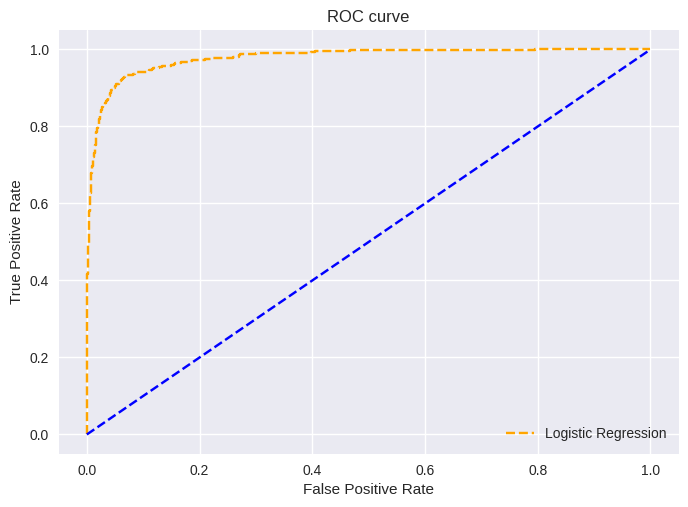

In [ ]:
# Evaluating the model on Validation dataset

import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Transforming the validation data into bag-of-words format using the same vectorizer
bow_test = text_ext_bow.transform(valid_data.text_preprocessed)

# Changing the label name
y_test = valid_data.propaganda_label

# Predicting the labels for validation data
y_pred = lr_best.predict(bow_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Get probabilities
y_pred_proba = lr_best.predict_proba(bow_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualize the ROC curve
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

**Observations:**

- The hyperparameter-tuned model maintains strong performance, with an **F1-score of 0.82 for the positive class (propagandistic) and 0.98 for the negative class (non-propagandistic)**.

- The hyperparameter tuning has further improved the model's performance on the validation dataset, particularly for the **positive class (propagandistic)**.

- The ROC curve illustrates the model's strong ability to balance true positive and false positive rates.

- The **class weights (class_weight={-1: 0.22, 1: 0.78})**continue to contribute to the model's effectiveness in handling class imbalance.

In [ ]:
# Checking test data

test_data.head()

,text_preprocessed,propaganda_label
0,"eat connecticut teamed end hunger connecticut (ehc) first ever 'culinary corner pub crawl,' jan. 20. crawl featured top blue back square pub restaurants. proceeds benefit ehc program outreach efforts. diner purchased special bracelets, entitled percent discount flora, vinted, india, cook bear, artisan restaurant. participant map stamped venue. jeannette dardenne, co owns eat connecticut, said crawl let community sample food drink west hartford premier restaurant support great cause. dardenne co owner kristen fritz founded social influencer group guide people fun activity supporting local c...",-1
1,"owner old pennsylvania power plant that’s target connecticut anti air pollution lawsuit reached deal sierra club stop burning coal facility peak summer ozone month starting 2023. agreement talen energy, owner high pollution brunner island generating facility, sierra club official halt burning coal power plant may september beginning start phase plan 2023. coal use year old plant ended consent decree, still need court approval. connecticut authority environmental group year demanding federal action clean pollution brunner island steam electric station. cite study showing emission plant drif...",-1
2,"majority owner president donald trump hotel latin america abruptly ordered trump employee property thursday, triggering confrontation trump employee refused leave asked police intervene, according trump organization local news reports. attempt takeover orestes fintiklis — cypriot businessman based miami — marked sharp escalation fintiklis month old effort brand trump international hotel panama replace trump organization manager. fintiklis blame trump brand trump company declining revenue empty rooms. but, far, tactic confined lawsuit angry letters. changed thursday, fintiklis group others ...",-1
3,"connecticut’s likely option using toll help fund transportation project involves “congestion pricing” system charge driver rush hour le peak times, according top state official. state could bring much $750 million year toll revenue using congestion pricing, according transportation commissioner james redeker. warned state commission last month would involve “tolling every interstate limited access [highway] state roads.” way achieve level revenue would put toll state roads, including route 2, 8, merritt parkway, redeker said december hearing commission fiscal stability economic growth. “we...",-1
4,"escaped prisoner jerry mercado back connecticut. year old hartford man escaped carl robinson correctional institution enfield jan. 7. housed northern correctional institution somers, known state’s supermax prison. mercado extradited canton, ga., held since arrest local police jan. 17. initially fought extradition, later waived right. caught, mercado bleached hair eyebrow made effort cover notorious neck tattoo reads: “time wait one.” department correction’s fugitive investigation unit, working concert u.s. marshal fugitive task force connecticut state police, developed intelligence placing...",-1


Confusion Matrix

[[8795  224]
 [ 259  881]]


Classification Report

              precision    recall  f1-score   support

          -1       0.97      0.98      0.97      9019
           1       0.80      0.77      0.78      1140

    accuracy                           0.95     10159
   macro avg       0.88      0.87      0.88     10159
weighted avg       0.95      0.95      0.95     10159


ROC AUC Score: 0.873985280586987


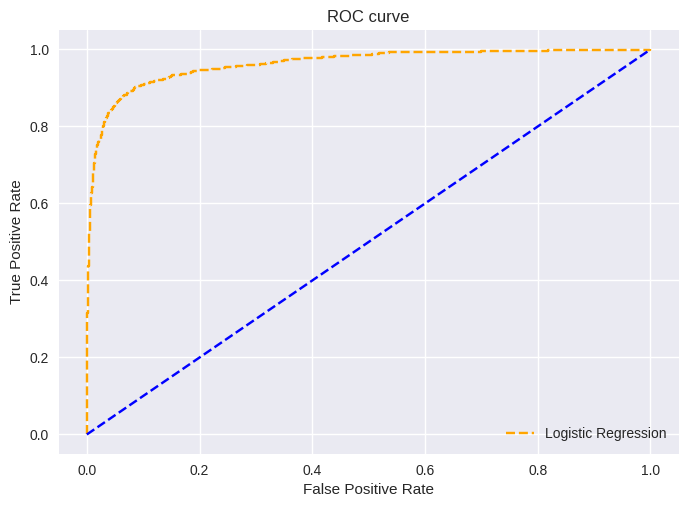

In [ ]:
# Evaluating the model on test dataset

# Transforming the validation data into bag-of-words format using the same vectorizer
bow_test = text_ext_bow.transform(test_data.text_preprocessed)

# Changing the label name
y_test = test_data.propaganda_label

# Predicting the labels for validation data
y_pred = lr_best.predict(bow_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Get probabilities
y_pred_proba = lr_best.predict_proba(bow_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualize the ROC curve
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

**Observations:**

- The hyperparameter tuning has maintained the model's effectiveness in handling class imbalance and achieving strong performance on the test dataset.

- The ROC curve confirms the model's ability to balance true positive and false positive rates.

- Overall, the hyperparameter-tuned Logistic Regression model with BoW embedding continues to perform well on the test dataset, indicating its robustness and suitability for the task of classifying propagandistic and non-propagandistic articles in news data.

###**2.TF-IDF**

In [ ]:
# Selecting the features and the target variables

X = train_data["text_preprocessed"]
y = train_data["propaganda_label"]

In [ ]:
# Train-Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)

In [ ]:
# Set an bog of words object
text_ext_tfidf = TfidfVectorizer(analyzer='word',
                                ngram_range=(1, 3),
                                stop_words="english",
                                min_df = 100,
                                max_df = 0.90)

# Extracting features using train data
text_ext_tfidf.fit(X_train)

TfidfVectorizer(max_df=0.9, min_df=100, ngram_range=(1, 3),
                stop_words='english')

In [ ]:
# Transforming valid and test datasets into TF-IDF encoded features

X_tfidf_train = text_ext_tfidf.transform(X_train)

X_tfidf_test = text_ext_tfidf.transform(X_test)

X_tfidf_train.shape, X_tfidf_test.shape

((28788, 10108), (7198, 10108))

              precision    recall  f1-score   support

          -1       0.95      0.99      0.97      6394
           1       0.92      0.56      0.70       804

    accuracy                           0.95      7198
   macro avg       0.93      0.78      0.83      7198
weighted avg       0.94      0.95      0.94      7198



Text(0.5, 1.0, 'Confusion Matrix')

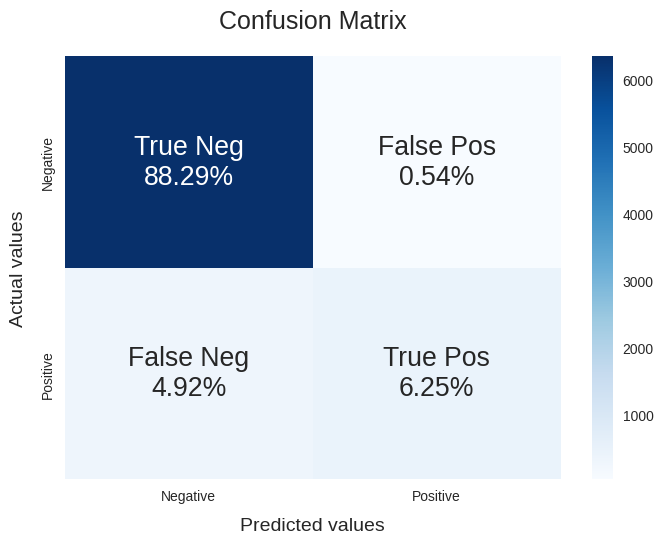

In [ ]:
# Logistic regression without class weight

logistic_regression = LogisticRegression(random_state=50)
logistic_regression.fit(X_tfidf_train, y_train)

# Predict on test data
y_pred = logistic_regression.predict(X_tfidf_test)


# Print classification report
print(classification_report(y_test, y_pred))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Observations:**

- The model has a higher performance for the majority class (non-propagandistic) and a relatively lower performance for the minority class (propagandistic).

- Similar to the BoW embedding, the TF-IDF embedding with logistic regression also faces challenges in classifying propagandistic articles accurately.

- The model may require further tuning or handling of class imbalance to improve performance on propagandistic articles.

              precision    recall  f1-score   support

          -1       0.97      0.97      0.97      6394
           1       0.74      0.73      0.73       804

    accuracy                           0.94      7198
   macro avg       0.85      0.85      0.85      7198
weighted avg       0.94      0.94      0.94      7198



Text(0.5, 1.0, 'Confusion Matrix')

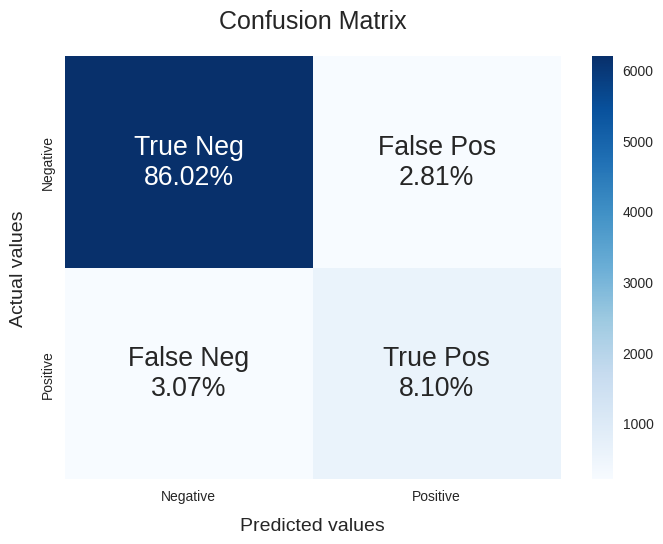

In [ ]:
# Logistic regression with class weight

logistic_regression = LogisticRegression(class_weight={-1:0.2, 1:0.8}, random_state=50)
logistic_regression.fit(X_tfidf_train, y_train)

# Predict on test data
y_pred = logistic_regression.predict(X_tfidf_test)


# Print classification report
print(classification_report(y_test, y_pred))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Observations:**

- Class weights have helped in balancing the model's performance for both classes, but there is a trade-off with a decrease in F1-score for the positive class (propagandistic).

- The model continues to have a strong performance for the majority class (non-propagandistic).

In [ ]:
%%time

# Hyperparameter tuning

# Creating model instance
lr = LogisticRegression(random_state = 50)

# Setting the range for class weights
weights = np.linspace(0.0, 0.99, 10)

# specifying all hyperparameters with possible values
param= {'C': [0.1, 0.5, 1, 10, 15, 20], 'penalty': ['l1', 'l2'], "class_weight":[{-1:x , 1:1.0 -x} for x in weights]}

# Create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 50)

# Hyperparameter tuning using Gridsearch
model= GridSearchCV(estimator= lr, param_grid=param, scoring="f1", cv = folds, return_train_score=True)

#train model to learn relationships between x and y
model.fit(X_tfidf_train, y_train)

CPU times: user 11min 20s, sys: 12min 31s, total: 23min 52s
Wall time: 14min 58s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=50, shuffle=True),
             estimator=LogisticRegression(random_state=50),
             param_grid={'C': [0.1, 0.5, 1, 10, 15, 20],
                         'class_weight': [{-1: 0.0, 1: 1.0},
                                          {-1: 0.11, 1: 0.89},
                                          {-1: 0.22, 1: 0.78},
                                          {-1: 0.33, 1: 0.6699999999999999},
                                          {-1: 0.44, 1: 0.56},
                                          {-1: 0.55, 1: 0.44999999999999996},
                                          {-1: 0.66, 1: 0.33999999999999997},
                                          {-1: 0.77, 1: 0.22999999999999998},
                                          {-1: 0.88, 1: 0.12},
                                          {-1: 0.99, 1: 0.010000000000000009}],
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1')

In [ ]:
# printing best hyperparameters

print("Best F1 score: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best F1 score:  0.8135249097293265
Best hyperparameters:  {'C': 15, 'class_weight': {-1: 0.33, 1: 0.6699999999999999}, 'penalty': 'l2'}


In [ ]:
# Building model again with best params

lr_best = LogisticRegression(class_weight = {-1: 0.33, 1: 0.67}, C = 15, penalty = "l2", random_state = 50)

lr_best.fit(X_tfidf_train, y_train)

LogisticRegression(C=15, class_weight={-1: 0.33, 1: 0.67}, random_state=50)

In [ ]:
# Train data performance

# Predict on test data
y_pred = lr_best.predict(X_tfidf_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.97      0.98      0.97      6394
           1       0.84      0.74      0.79       804

    accuracy                           0.96      7198
   macro avg       0.90      0.86      0.88      7198
weighted avg       0.95      0.96      0.95      7198



Confusion Matrix

[[6283  111]
 [ 212  592]]


Classification Report

              precision    recall  f1-score   support

          -1       0.97      0.98      0.97      6394
           1       0.84      0.74      0.79       804

    accuracy                           0.96      7198
   macro avg       0.90      0.86      0.88      7198
weighted avg       0.95      0.96      0.95      7198


ROC AUC Score: 0.8594791914683698


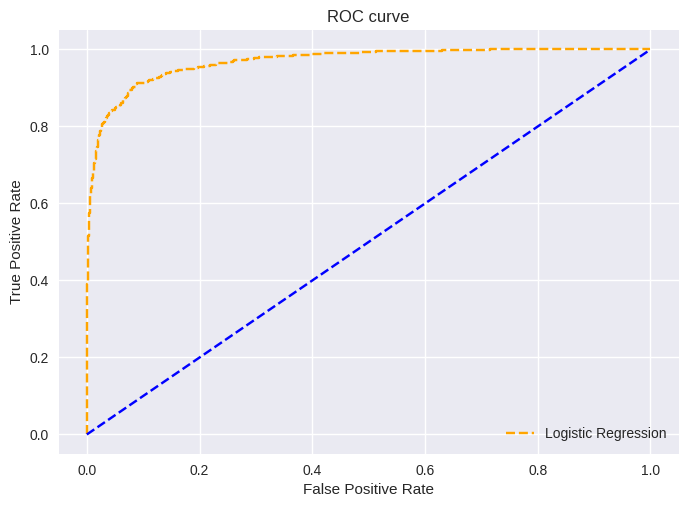

In [ ]:
# Evaluating the model on Training data

# Predicting the labels for train data
y_pred = lr_best.predict(X_tfidf_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Get probabilities
y_pred_proba = lr_best.predict_proba(X_tfidf_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualize the ROC curve
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

**Observations:**

- The ROC AUC score is 0.859, indicating good discrimination ability between the two classes.

- The hyperparameter tuning has further improved the model's performance on the test dataset, particularly for the positive class (propagandistic).

- The ROC curve illustrates the model's strong ability to balance true positive and false positive rates.

In [ ]:
# Checking validation data

valid_data.head()

,text_preprocessed,propaganda_label
0,"convened examine cause civil unrest black communities, presidential commission issued report stark conclusion: america moving towards two societies, ""one black, one white — separate unequal."" fifty year historic kerner commission identified ""white racism"" key cause ""pervasive discrimination employment, education housing,"" progress african american fare comparison white come homeownership, unemployment incarceration, according report economic policy institute released monday. cases, african american worse today civil right movement culminated law barring housing voter discrimination well ra...",-1
1,"discriminating someone basis sexual orientation prohibited federal civil right law, federal appeal court ruled monday sided gay skydiving instructor fired job discussing sexuality client. decision u.s. court appeal 2nd circuit offer expanded protection lgbt people mark significant loss president donald trump justice department, filed brief arguing title vii civil right act cover sexual orientation discrimination. state law still murky, federal circuit part country issued mixed opinions. ruling 2nd circuit, based manhattan, could appealed supreme court. justice department spokesman devin o'...",-1
2,"bill cosby year old daughter, ensa cosby, died massachusetts kidney disease, spokesman comedian said monday. spokesman andrew wyatt immediately offer detail death friday. ""please keep cosby family prayer give peace time,"" said. bill cosby lost another five child year old son, ennis, graduate student columbia university, shot death changing flat tire near freeway ramp los angeles. year old man later convicted sentenced life prison without parole. bill cosby, 80, owns home western massachusetts town shelburne falls. ensa cosby spoke father behalf trial last year charge drugged molested woman...",-1
3,"fast moving, powerful theatrical locomotive “murder orient express” hartford stage march 25, make stop syria, paris snowbound, tree lined landscape between. really want broadway. though character speak host top european accents, patter new york snappy. show’s designer broadway regular — costume designer extraordinaire william ivey long (a natural gig, done recent broadway revival “on twentieth century”), scenic designer beowulf boritt (“come away,” “meteor shower”), lighting designer ken billington (who worked boritt “sunday park george” “act one”), sound designer darron l. west (a regular...",-1
4,"friday. national pizza day. grab life slice. not? connecticut all. footing national pizza lore remains solid ever. hartford, option pie plentiful. new haven, even better — like thin slightly charred. hardest choice, without doubt, go. you’re bold, take tour. half dozen option you’re hartford area: angelina’s hartford. boast biggest slice around. true pizza detective needed investigate claim, likely won’t leave hungry. handout angelina is: prospect ave, hartford, ct angelina is: prospect ave, hartford, ct (handout) couple turn away, you’ve got lena’s first & last pizzaria hartford parkville...",-1


Confusion Matrix

[[4474   76]
 [ 106  469]]


Classification Report

              precision    recall  f1-score   support

          -1       0.98      0.98      0.98      4550
           1       0.86      0.82      0.84       575

    accuracy                           0.96      5125
   macro avg       0.92      0.90      0.91      5125
weighted avg       0.96      0.96      0.96      5125


ROC AUC Score: 0.8994744386048734


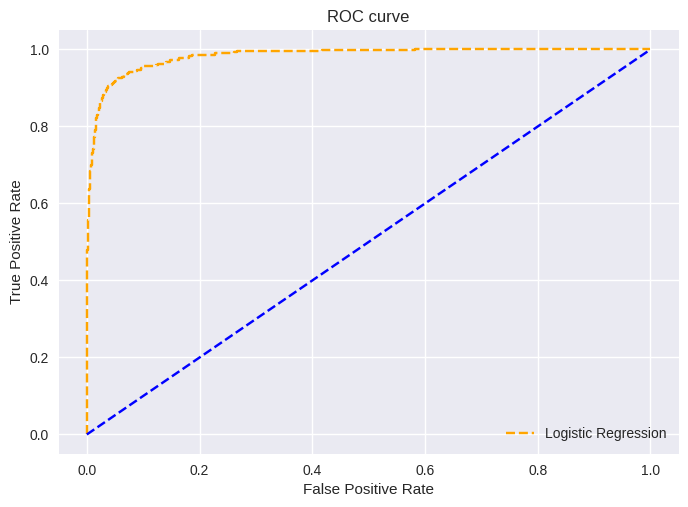

In [ ]:
# Evaluating the model on Validation dataset

# Transforming the validation data into bag-of-words format using the same vectorizer
X_tfidf_test = text_ext_tfidf.transform(valid_data.text_preprocessed)

# Changing the label name
y_test = valid_data.propaganda_label

# Predicting the labels for validation data
y_pred = lr_best.predict(X_tfidf_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Get probabilities
y_pred_proba = lr_best.predict_proba(X_tfidf_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualize the ROC curve
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

**Observations:**

- The hyperparameter tuning has further improved the model's performance on the validation dataset, particularly for the positive class (propagandistic).

- The ROC curve illustrates the model's strong ability to balance true positive and false positive rates.

- Overall, the hyperparameter-tuned Logistic Regression model with TF-IDF embedding continues to perform well on the validation dataset, indicating its robustness and suitability for the task of classifying propagandistic and non-propagandistic articles in news data.

In [ ]:
# Checking test data

test_data.head()

,text_preprocessed,propaganda_label
0,"eat connecticut teamed end hunger connecticut (ehc) first ever 'culinary corner pub crawl,' jan. 20. crawl featured top blue back square pub restaurants. proceeds benefit ehc program outreach efforts. diner purchased special bracelets, entitled percent discount flora, vinted, india, cook bear, artisan restaurant. participant map stamped venue. jeannette dardenne, co owns eat connecticut, said crawl let community sample food drink west hartford premier restaurant support great cause. dardenne co owner kristen fritz founded social influencer group guide people fun activity supporting local c...",-1
1,"owner old pennsylvania power plant that’s target connecticut anti air pollution lawsuit reached deal sierra club stop burning coal facility peak summer ozone month starting 2023. agreement talen energy, owner high pollution brunner island generating facility, sierra club official halt burning coal power plant may september beginning start phase plan 2023. coal use year old plant ended consent decree, still need court approval. connecticut authority environmental group year demanding federal action clean pollution brunner island steam electric station. cite study showing emission plant drif...",-1
2,"majority owner president donald trump hotel latin america abruptly ordered trump employee property thursday, triggering confrontation trump employee refused leave asked police intervene, according trump organization local news reports. attempt takeover orestes fintiklis — cypriot businessman based miami — marked sharp escalation fintiklis month old effort brand trump international hotel panama replace trump organization manager. fintiklis blame trump brand trump company declining revenue empty rooms. but, far, tactic confined lawsuit angry letters. changed thursday, fintiklis group others ...",-1
3,"connecticut’s likely option using toll help fund transportation project involves “congestion pricing” system charge driver rush hour le peak times, according top state official. state could bring much $750 million year toll revenue using congestion pricing, according transportation commissioner james redeker. warned state commission last month would involve “tolling every interstate limited access [highway] state roads.” way achieve level revenue would put toll state roads, including route 2, 8, merritt parkway, redeker said december hearing commission fiscal stability economic growth. “we...",-1
4,"escaped prisoner jerry mercado back connecticut. year old hartford man escaped carl robinson correctional institution enfield jan. 7. housed northern correctional institution somers, known state’s supermax prison. mercado extradited canton, ga., held since arrest local police jan. 17. initially fought extradition, later waived right. caught, mercado bleached hair eyebrow made effort cover notorious neck tattoo reads: “time wait one.” department correction’s fugitive investigation unit, working concert u.s. marshal fugitive task force connecticut state police, developed intelligence placing...",-1


Confusion Matrix

[[8865  154]
 [ 279  861]]


Classification Report

              precision    recall  f1-score   support

          -1       0.97      0.98      0.98      9019
           1       0.85      0.76      0.80      1140

    accuracy                           0.96     10159
   macro avg       0.91      0.87      0.89     10159
weighted avg       0.96      0.96      0.96     10159


ROC AUC Score: 0.8690940470702202


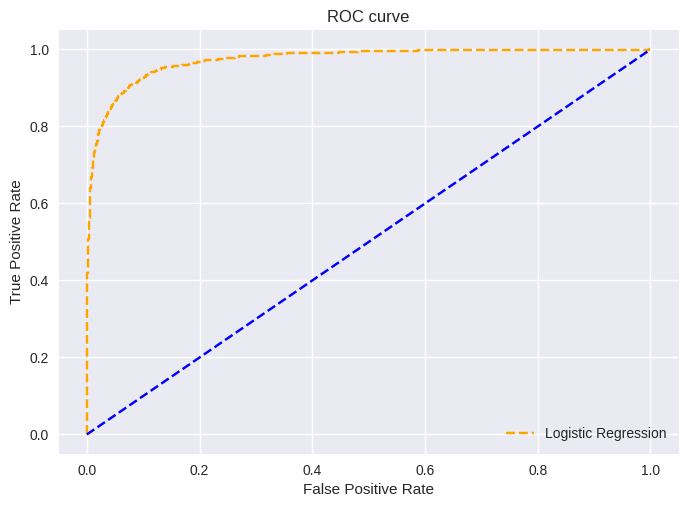

In [ ]:
# Evaluating the model on test dataset

# Transforming the validation data into bag-of-words format using the same vectorizer
X_tfidf_test = text_ext_tfidf.transform(test_data.text_preprocessed)

# Changing the label name
y_test = test_data.propaganda_label

# Predicting the labels for validation data
y_pred = lr_best.predict(X_tfidf_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Get probabilities
y_pred_proba = lr_best.predict_proba(X_tfidf_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualize the ROC curve
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

**Observations:**

- The hyperparameter tuning has further improved the model's performance on the test dataset, particularly for the positive class (propagandistic).

- The ROC curve illustrates the model's strong ability to balance true positive and false positive rates.

- Overall, the hyperparameter-tuned Logistic Regression model with TF-IDF embedding continues to perform well on the test dataset, indicating its robustness and suitability for the task of classifying propagandistic and non-propagandistic articles in news data.

### **3. Word2Vec**

In [ ]:
train_data

,text_preprocessed,propaganda_label
0,et tu rhody recent editorial providence journal cataloged everything could find wrong connecticut ended suggestion gov gina raimondo see least job could come rhode island certainly le risky nutmeg state beg pardon state world famous pension problem persistent economic issue le risky journal reported week ago rhode island significant economic problem many way reflect connecticut rhode island enjoys legacy corruption even connecticut match projo pulitzer prize uncovering widespread corruption within court system exactly gained moving rhode island like connecticut rhode island income tax esta...,-1
1,recent post farmington mirror town version onion encouraged parent take advantage shuttle service offered town brings child school location close proximity home also free decision follows complaint made social medium regarding long parent drop line post read mirror note shuttle easily identifiable bright yellow color traffic stopping flashing red light appears practice driving student school privately owned car began sometime 1980s school thing drop line mid 2000s parent seemed aghast learn actually let child ride school bus sometimes way moved house within walking distance neighborhood el...,-1
2,president donald trump often responding natural disaster mass shooting unfolding crisis spent much time congratulating responder rather memorializing victim wednesday school shooting visit friday trump two quick visit hospital sheriff office near school killed score injured praised doctor police officer fire official others responded quickly mass shooting parkland florida casting response heroic record setting incredible job everybody talking trump said response dozen officer flanked around large circular conference room table fifth floor broward county sheriff office trump said saw victim...,-1
3,february black history month nothing loom larger black history evil specter slavery three exhibit state take subject two inspired notorious slave trading center shore africa third pay tribute legendary escaped slave abolitionist leader frederick douglas door return robert charles hudson haunted might called corridor doom pathway arena trod ill fated roman gladiator queue walked concentration camp inmate toward gas chamber hudson exhibit hartford public library artwalk gallery door return focus one corridor kidnapped african walked ship headed america door metaphor man inhumanity man enslav...,-1
4,snow heavy whipped gusting wind travel nearly impossible thousand abandoned car ambulance could pas massive drift cohort four wheel drive owner called upon gov ella grasso aid rescue courant reporter david bailey wrote transportation shamble snow reported made walking nearly dangerous driving many sought shelter wherever could year since blizzard snow record stand day leading storm forecaster warned could wallop state right area saw much foot snow driven drift high wind grasso declared state emergency urged car road many stuck people futile attempt get home business told shutter well shutd...,-1
...,...,...
35981,telegraph town brazil become refugee camp tide desperate venezuelan august 600am johan rodriguez builder trade one thousand venezuelan fled across border brazil escape unravelling economy country situation hard kid said mr rodriguez make eat eat young daughter pregnant wife camping side street boa vista brazil since fled venezuela month ago life venezuela pretty awful day people fleeing boa vista amazoncom gift card buy new est detail boa vista destination expedition writer evelyn waugh mounted crossed savannah british guiana foot recounted travel book ninety two day weary journey several ...,1
35982,second episode consortium news flash point focus two different perspective john mccain real meaning russian interference u politics collaboration dennis bernstein host pacifica radio syndicated show flash point consortium news present second episode consortium news flash point recorded produced berkeley californ

In [ ]:
# Selecting the features and the target variables

X = train_data["text_preprocessed"]
y = train_data["propaganda_label"]

In [ ]:
# Train-Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)

In [ ]:
# Creating train/test list of sentences

train_articles = [sentence.split() for sentence in X_train]
test_articles = [sentence.split() for sentence in X_test]

In [ ]:
# training Word2Vectors

w2v_model = Word2Vec(train_articles, min_count=5, vector_size=50, workers=-1) # considering only words that occured atleast 5 times

print(w2v_model.wv.most_similar('trump'))

print('='*50)

print(w2v_model.wv.most_similar('economy'))

[('reuters', 0.5417647957801819), ('learning', 0.5342778563499451), ('tricking', 0.509909451007843), ('spite', 0.49874505400657654), ('moreno', 0.48862141370773315), ('newark', 0.487811803817749), ('analogy', 0.47630465030670166), ('surname', 0.47482389211654663), ('imago', 0.474642276763916), ('liquidated', 0.46862030029296875)]
[('arabiyanet', 0.5285916924476624), ('episcopacy', 0.5268168449401855), ('standoff', 0.5043067336082458), ('thoroughfare', 0.49849212169647217), ('stockbridge', 0.49277597665786743), ('stanton', 0.49129483103752136), ('nashwauk', 0.48784542083740234), ('indoor', 0.4865754544734955), ('reminded', 0.4852547347545624), ('sabotage', 0.48399677872657776)]


In [ ]:
w2v_words = list(w2v_model.wv.index_to_key)

print("number of words that occured minimum 5 times ", len(w2v_words))

print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  50565
sample words  ['said', 'year', 'u', 'trump', 'state', 'would', 'one', 'also', 'people', 'president', 'time', 'new', 'government', 'country', 'two', 'last', 'say', 'day', 'could', 'first', 'like', 'may', 'right', 'police', 'told', 'school', 'house', 'official', 'law', 'according', 'iran', 'court', 'group', 'american', 'news', 'many', 'even', 'party', 'make', 'report', 'minister', 'israel', 'week', 'world', 'get', 'made', 'case', 'north', 'city', 'month']


In [ ]:
# Transforming preprocessed text data into Word2Vec encoded features

import numpy as np

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_w2v_train = np.array([vectorize(sentence) for sentence in X_train])
X_w2v_test = np.array([vectorize(sentence) for sentence in X_test])

X_w2v_train.shape, X_w2v_test.shape

((28788, 50), (7198, 50))

              precision    recall  f1-score   support

          -1       0.89      1.00      0.94      6394
           1       0.00      0.00      0.00       804

    accuracy                           0.89      7198
   macro avg       0.44      0.50      0.47      7198
weighted avg       0.79      0.89      0.84      7198



Text(0.5, 1.0, 'Confusion Matrix')

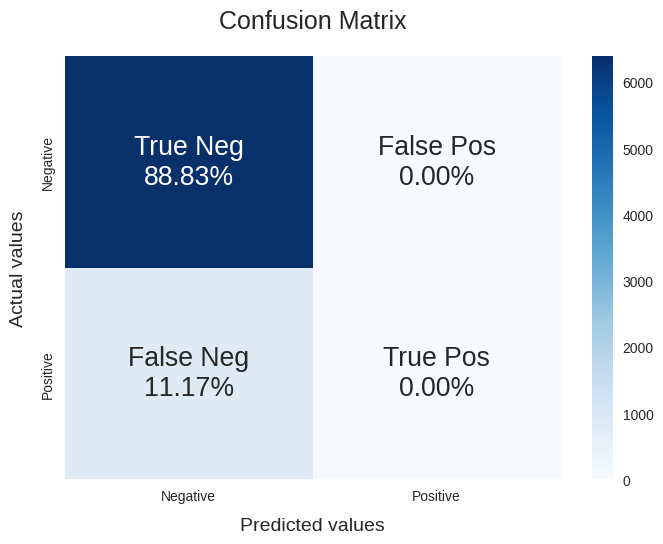

In [ ]:
# Logistic regression without class weight

logistic_regression = LogisticRegression(random_state=50)
logistic_regression.fit(X_w2v_train, y_train)

# Predict on test data
y_pred = logistic_regression.predict(X_w2v_test)


# Print classification report
print(classification_report(y_test, y_pred))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Observations:**

- The F1-score for the **negative class (-1) is 0.94**, indicating good precision and recall for identifying non-propagandistic articles.

- However, the F1-score for the **positive class (1) is 0.00**, indicating that the model is unable to correctly classify propagandistic articles.

- Word2Vec embeddings may not be well-suited for this task or may require further preprocessing or fine-tuning.

- The model's inability to correctly classify propagandistic articles is a significant limitation, and alternative approaches should be explored.

              precision    recall  f1-score   support

          -1       0.89      1.00      0.94      6394
           1       0.00      0.00      0.00       804

    accuracy                           0.89      7198
   macro avg       0.44      0.50      0.47      7198
weighted avg       0.79      0.89      0.84      7198



Text(0.5, 1.0, 'Confusion Matrix')

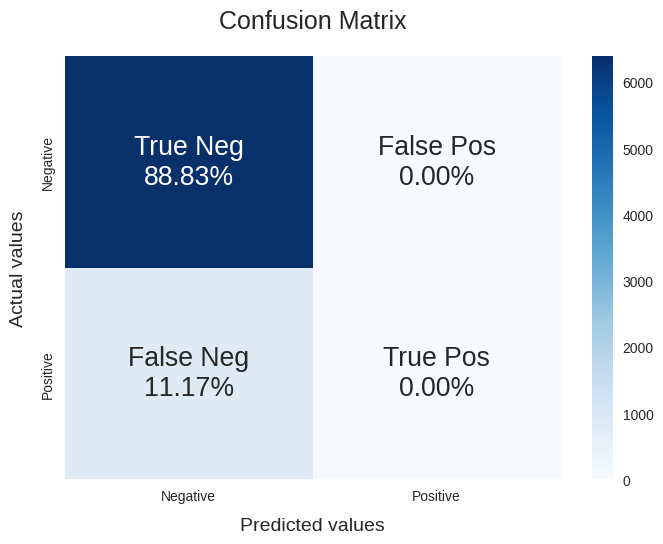

In [ ]:
# Logistic regression with class weight

logistic_regression = LogisticRegression(class_weight={-1:0.2, 1:0.8}, random_state=50)
logistic_regression.fit(X_w2v_train, y_train)

# Predict on test data
y_pred = logistic_regression.predict(X_w2v_test)


# Print classification report
print(classification_report(y_test, y_pred))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Observations:**

- Despite applying class weights, the model is still unable to effectively classify propagandistic articles using Word2Vec embeddings.

- Word2Vec embeddings may not capture the semantic information required for this classification task, and other embedding techniques or models should be explored.

In [ ]:
%%time

# Hyperparameter tuning

# Creating model instance
lr = LogisticRegression(random_state = 50)

# Setting the range for class weights
weights = np.linspace(0.0, 0.99, 10)

# specifying all hyperparameters with possible values
param= {'C': [0.1, 0.5, 1, 10, 15, 20], 'penalty': ['l1', 'l2'], "class_weight":[{-1:x , 1:1.0 -x} for x in weights]}

# Create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 50)

# Hyperparameter tuning using Gridsearch
model= GridSearchCV(estimator= lr, param_grid=param, scoring="f1", cv = folds, return_train_score=True)

#train model to learn relationships between x and y
model.fit(X_w2v_train, y_train)

CPU times: user 44.1 s, sys: 20.6 s, total: 1min 4s
Wall time: 41.7 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=50, shuffle=True),
             estimator=LogisticRegression(random_state=50),
             param_grid={'C': [0.1, 0.5, 1, 10, 15, 20],
                         'class_weight': [{-1: 0.0, 1: 1.0},
                                          {-1: 0.11, 1: 0.89},
                                          {-1: 0.22, 1: 0.78},
                                          {-1: 0.33, 1: 0.6699999999999999},
                                          {-1: 0.44, 1: 0.56},
                                          {-1: 0.55, 1: 0.44999999999999996},
                                          {-1: 0.66, 1: 0.33999999999999997},
                                          {-1: 0.77, 1: 0.22999999999999998},
                                          {-1: 0.88, 1: 0.12},
                                          {-1: 0.99, 1: 0.010000000000000009}],
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1')

In [ ]:
# printing best hyperparameters

print("Best F1 score: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best F1 score:  0.2982364447305903
Best hyperparameters:  {'C': 20, 'class_weight': {-1: 0.11, 1: 0.89}, 'penalty': 'l2'}


In [ ]:
# Building model again with best params

lr_best = LogisticRegression(class_weight = {-1: 0.11, 1: 0.89}, C = 20, penalty = "l2", random_state = 50)

lr_best.fit(X_w2v_train, y_train)

LogisticRegression(C=20, class_weight={-1: 0.11, 1: 0.89}, random_state=50)

Confusion Matrix

[[3374 3020]
 [ 123  681]]


Classification Report

              precision    recall  f1-score   support

          -1       0.96      0.53      0.68      6394
           1       0.18      0.85      0.30       804

    accuracy                           0.56      7198
   macro avg       0.57      0.69      0.49      7198
weighted avg       0.88      0.56      0.64      7198


ROC AUC Score: 0.6873485637187848


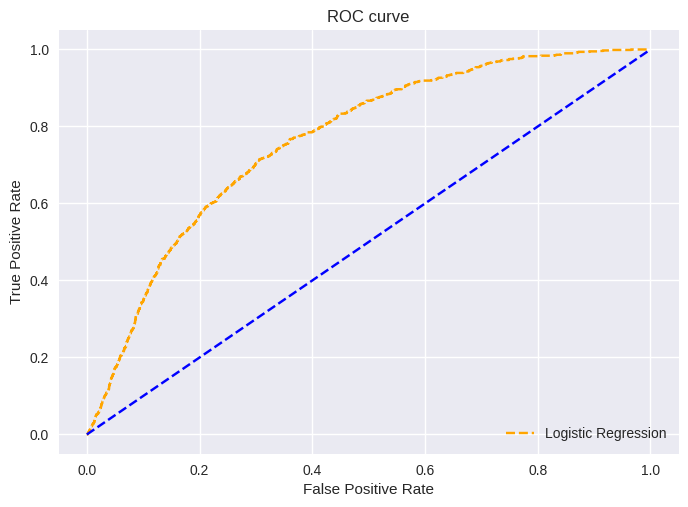

In [ ]:
# Evaluating the model on Training data

# Predicting the labels for train data
y_pred = lr_best.predict(X_w2v_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Get probabilities
y_pred_proba = lr_best.predict_proba(X_w2v_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualize the ROC curve
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

**Observations:**

- The model seems to be biased towards predicting the positive class (propagandistic), as indicated by the high recall but low precision for this class.

- The ROC AUC score of 0.69 suggests that the model has some ability to discriminate between the two classes, but its overall performance remains limited.

In [ ]:
# Checking validation data

valid_data.head()

,text_preprocessed,propaganda_label
0,"convened examine cause civil unrest black communities, presidential commission issued report stark conclusion: america moving towards two societies, ""one black, one white — separate unequal."" fifty year historic kerner commission identified ""white racism"" key cause ""pervasive discrimination employment, education housing,"" progress african american fare comparison white come homeownership, unemployment incarceration, according report economic policy institute released monday. cases, african american worse today civil right movement culminated law barring housing voter discrimination well ra...",-1
1,"discriminating someone basis sexual orientation prohibited federal civil right law, federal appeal court ruled monday sided gay skydiving instructor fired job discussing sexuality client. decision u.s. court appeal 2nd circuit offer expanded protection lgbt people mark significant loss president donald trump justice department, filed brief arguing title vii civil right act cover sexual orientation discrimination. state law still murky, federal circuit part country issued mixed opinions. ruling 2nd circuit, based manhattan, could appealed supreme court. justice department spokesman devin o'...",-1
2,"bill cosby year old daughter, ensa cosby, died massachusetts kidney disease, spokesman comedian said monday. spokesman andrew wyatt immediately offer detail death friday. ""please keep cosby family prayer give peace time,"" said. bill cosby lost another five child year old son, ennis, graduate student columbia university, shot death changing flat tire near freeway ramp los angeles. year old man later convicted sentenced life prison without parole. bill cosby, 80, owns home western massachusetts town shelburne falls. ensa cosby spoke father behalf trial last year charge drugged molested woman...",-1
3,"fast moving, powerful theatrical locomotive “murder orient express” hartford stage march 25, make stop syria, paris snowbound, tree lined landscape between. really want broadway. though character speak host top european accents, patter new york snappy. show’s designer broadway regular — costume designer extraordinaire william ivey long (a natural gig, done recent broadway revival “on twentieth century”), scenic designer beowulf boritt (“come away,” “meteor shower”), lighting designer ken billington (who worked boritt “sunday park george” “act one”), sound designer darron l. west (a regular...",-1
4,"friday. national pizza day. grab life slice. not? connecticut all. footing national pizza lore remains solid ever. hartford, option pie plentiful. new haven, even better — like thin slightly charred. hardest choice, without doubt, go. you’re bold, take tour. half dozen option you’re hartford area: angelina’s hartford. boast biggest slice around. true pizza detective needed investigate claim, likely won’t leave hungry. handout angelina is: prospect ave, hartford, ct angelina is: prospect ave, hartford, ct (handout) couple turn away, you’ve got lena’s first & last pizzaria hartford parkville...",-1


Confusion Matrix

[[2156 2394]
 [  76  499]]


Classification Report

              precision    recall  f1-score   support

          -1       0.97      0.47      0.64      4550
           1       0.17      0.87      0.29       575

    accuracy                           0.52      5125
   macro avg       0.57      0.67      0.46      5125
weighted avg       0.88      0.52      0.60      5125


ROC AUC Score: 0.6708361204013378


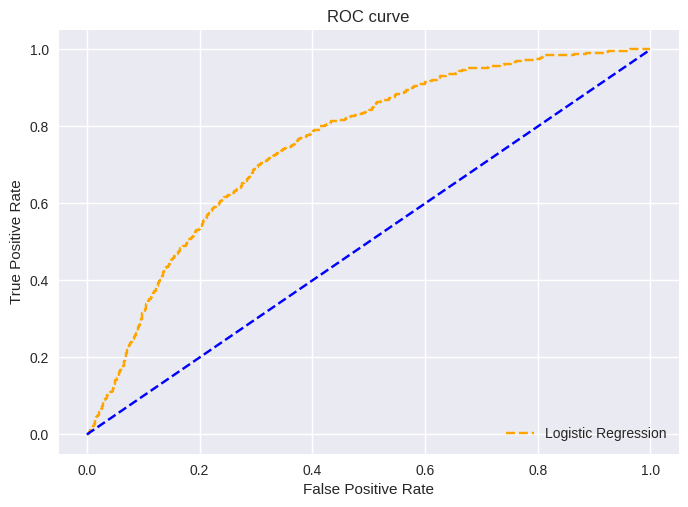

In [ ]:
# Evaluating the model on Validation dataset

# Transforming the validation data into word2vec format using the same vectorizer
X_w2v_test = np.array([vectorize(sentence) for sentence in valid_data.text_preprocessed])


# Changing the label name
y_test = valid_data.propaganda_label

# Predicting the labels for validation data
y_pred = lr_best.predict(X_w2v_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Get probabilities
y_pred_proba = lr_best.predict_proba(X_w2v_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualize the ROC curve
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

**Observations:**

- Similar to the training data, the model appears to be biased towards predicting the positive class (propagandistic), as indicated by the high recall but low precision for this class.

In [ ]:
# Checking test data

test_data.head()

,text_preprocessed,propaganda_label
0,"eat connecticut teamed end hunger connecticut (ehc) first ever 'culinary corner pub crawl,' jan. 20. crawl featured top blue back square pub restaurants. proceeds benefit ehc program outreach efforts. diner purchased special bracelets, entitled percent discount flora, vinted, india, cook bear, artisan restaurant. participant map stamped venue. jeannette dardenne, co owns eat connecticut, said crawl let community sample food drink west hartford premier restaurant support great cause. dardenne co owner kristen fritz founded social influencer group guide people fun activity supporting local c...",-1
1,"owner old pennsylvania power plant that’s target connecticut anti air pollution lawsuit reached deal sierra club stop burning coal facility peak summer ozone month starting 2023. agreement talen energy, owner high pollution brunner island generating facility, sierra club official halt burning coal power plant may september beginning start phase plan 2023. coal use year old plant ended consent decree, still need court approval. connecticut authority environmental group year demanding federal action clean pollution brunner island steam electric station. cite study showing emission plant drif...",-1
2,"majority owner president donald trump hotel latin america abruptly ordered trump employee property thursday, triggering confrontation trump employee refused leave asked police intervene, according trump organization local news reports. attempt takeover orestes fintiklis — cypriot businessman based miami — marked sharp escalation fintiklis month old effort brand trump international hotel panama replace trump organization manager. fintiklis blame trump brand trump company declining revenue empty rooms. but, far, tactic confined lawsuit angry letters. changed thursday, fintiklis group others ...",-1
3,"connecticut’s likely option using toll help fund transportation project involves “congestion pricing” system charge driver rush hour le peak times, according top state official. state could bring much $750 million year toll revenue using congestion pricing, according transportation commissioner james redeker. warned state commission last month would involve “tolling every interstate limited access [highway] state roads.” way achieve level revenue would put toll state roads, including route 2, 8, merritt parkway, redeker said december hearing commission fiscal stability economic growth. “we...",-1
4,"escaped prisoner jerry mercado back connecticut. year old hartford man escaped carl robinson correctional institution enfield jan. 7. housed northern correctional institution somers, known state’s supermax prison. mercado extradited canton, ga., held since arrest local police jan. 17. initially fought extradition, later waived right. caught, mercado bleached hair eyebrow made effort cover notorious neck tattoo reads: “time wait one.” department correction’s fugitive investigation unit, working concert u.s. marshal fugitive task force connecticut state police, developed intelligence placing...",-1


Confusion Matrix

[[4219 4800]
 [ 113 1027]]


Classification Report

              precision    recall  f1-score   support

          -1       0.97      0.47      0.63      9019
           1       0.18      0.90      0.29      1140

    accuracy                           0.52     10159
   macro avg       0.58      0.68      0.46     10159
weighted avg       0.88      0.52      0.59     10159


ROC AUC Score: 0.6843337068138803


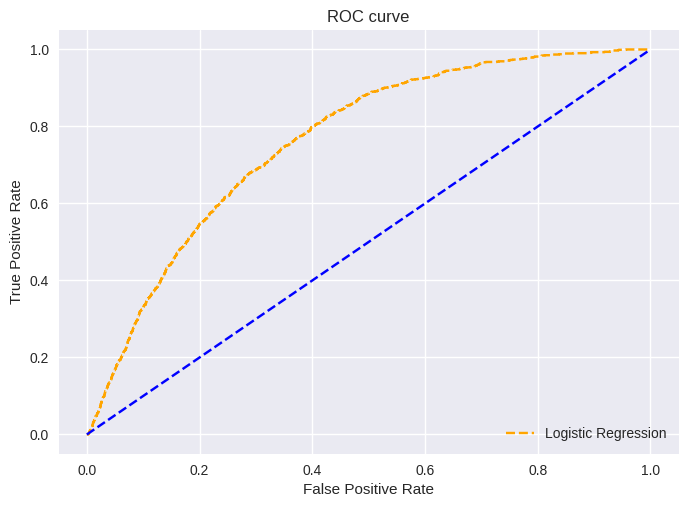

In [ ]:
# Evaluating the model on test dataset

# Transforming the validation data into word2vec format using the same vectorizer
X_w2v_test = np.array([vectorize(sentence) for sentence in test_data.text_preprocessed])

# Changing the label name
y_test = test_data.propaganda_label

# Predicting the labels for validation data
y_pred = lr_best.predict(X_w2v_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Get probabilities
y_pred_proba = lr_best.predict_proba(X_w2v_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualize the ROC curve
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

**Observations:**

- Similar to the training and validation datasets, the model still exhibits a bias toward predicting the positive class (propagandistic), as indicated by the high recall but low precision for this class.

- The model's performance on the test dataset does not substantially differ from its performance on the validation data, indicating that the model has not overfit or underfit the training data.

- Overall, it appears that the logistic regression model with Word2Vec embedding and the current hyperparameters is not effectively capturing the patterns in the data to distinguish between propagandistic and non-propagandistic articles.

### **4.Google News Vectors - Word2Vec Model**

In [ ]:
train_data

,text_preprocessed,propaganda_label
0,et tu rhody recent editorial providence journal cataloged everything could find wrong connecticut ended suggestion gov gina raimondo see least job could come rhode island certainly le risky nutmeg state beg pardon state world famous pension problem persistent economic issue le risky journal reported week ago rhode island significant economic problem many way reflect connecticut rhode island enjoys legacy corruption even connecticut match projo pulitzer prize uncovering widespread corruption within court system exactly gained moving rhode island like connecticut rhode island income tax esta...,-1
1,recent post farmington mirror town version onion encouraged parent take advantage shuttle service offered town brings child school location close proximity home also free decision follows complaint made social medium regarding long parent drop line post read mirror note shuttle easily identifiable bright yellow color traffic stopping flashing red light appears practice driving student school privately owned car began sometime 1980s school thing drop line mid 2000s parent seemed aghast learn actually let child ride school bus sometimes way moved house within walking distance neighborhood el...,-1
2,president donald trump often responding natural disaster mass shooting unfolding crisis spent much time congratulating responder rather memorializing victim wednesday school shooting visit friday trump two quick visit hospital sheriff office near school killed score injured praised doctor police officer fire official others responded quickly mass shooting parkland florida casting response heroic record setting incredible job everybody talking trump said response dozen officer flanked around large circular conference room table fifth floor broward county sheriff office trump said saw victim...,-1
3,february black history month nothing loom larger black history evil specter slavery three exhibit state take subject two inspired notorious slave trading center shore africa third pay tribute legendary escaped slave abolitionist leader frederick douglas door return robert charles hudson haunted might called corridor doom pathway arena trod ill fated roman gladiator queue walked concentration camp inmate toward gas chamber hudson exhibit hartford public library artwalk gallery door return focus one corridor kidnapped african walked ship headed america door metaphor man inhumanity man enslav...,-1
4,snow heavy whipped gusting wind travel nearly impossible thousand abandoned car ambulance could pas massive drift cohort four wheel drive owner called upon gov ella grasso aid rescue courant reporter david bailey wrote transportation shamble snow reported made walking nearly dangerous driving many sought shelter wherever could year since blizzard snow record stand day leading storm forecaster warned could wallop state right area saw much foot snow driven drift high wind grasso declared state emergency urged car road many stuck people futile attempt get home business told shutter well shutd...,-1
...,...,...
35981,telegraph town brazil become refugee camp tide desperate venezuelan august 600am johan rodriguez builder trade one thousand venezuelan fled across border brazil escape unravelling economy country situation hard kid said mr rodriguez make eat eat young daughter pregnant wife camping side street boa vista brazil since fled venezuela month ago life venezuela pretty awful day people fleeing boa vista amazoncom gift card buy new est detail boa vista destination expedition writer evelyn waugh mounted crossed savannah british guiana foot recounted travel book ninety two day weary journey several ...,1
35982,second episode consortium news flash point focus two different perspective john mccain real meaning russian interference u politics collaboration dennis bernstein host pacifica radio syndicated show flash point consortium news present second episode consortium news flash point recorded produced berkeley californ

In [ ]:
# Selecting the features and the target variables

X = train_data["text_preprocessed"]

y = train_data["propaganda_label"]

In [ ]:
# Train-Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)

In [ ]:
# Creating train/test list of sentences

train_articles = [sentence.split() for sentence in X_train]
test_articles = [sentence.split() for sentence in X_test]

In [ ]:
%%time

# Path to dataset
word2vec_path = "/content/drive/My Drive/Design Project/GoogleNews-vectors-negative300.bin.gz"

# Load 200,000 most common words
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=200000)

CPU times: user 3.96 s, sys: 346 ms, total: 4.3 s
Wall time: 5.73 s


In [ ]:
# Get word vector
test_word = w2v_model['election']

# Print shape and vector
print('Vector dimension:', test_word.shape)

Vector dimension: (300,)


In [ ]:
# Query word vectors
word = 'trump'
most_similar_words = w2v_model.most_similar(word)
similarity_score = w2v_model.similarity('trump', 'business')

print(f"Most similar words to '{word}': {most_similar_words}")
print(f"Similarity score between 'trump' and 'business': {similarity_score}")

Most similar words to 'trump': [('trumps', 0.7198434472084045), ('trumping', 0.580585241317749), ('supersede', 0.5600422620773315), ('trumped', 0.5497318506240845), ('supercede', 0.5309919118881226), ('prevail', 0.487763375043869), ('outweigh', 0.47853273153305054), ('trample', 0.4714253544807434), ('overshadow', 0.4701153635978699), ('dictate', 0.46754559874534607)]
Similarity score between 'trump' and 'business': 0.07233818620443344


In [ ]:
w2v_words = list(w2v_model.index_to_key)

print("number of words that occured minimum 5 times ", len(w2v_words))

print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  200000
sample words  ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', '$', 'had', 'year', 'were', 'we', 'more', '###', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out']


In [ ]:
# Transforming preprocessed text data into Word2Vec encoded features

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model[word] for word in words if word in w2v_model]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_w2v_train = np.array([vectorize(sentence) for sentence in X_train])
X_w2v_test = np.array([vectorize(sentence) for sentence in X_test])

X_w2v_train.shape, X_w2v_test.shape

((28788, 300), (7198, 300))

              precision    recall  f1-score   support

          -1       0.93      0.98      0.96      6394
           1       0.77      0.40      0.52       804

    accuracy                           0.92      7198
   macro avg       0.85      0.69      0.74      7198
weighted avg       0.91      0.92      0.91      7198



Text(0.5, 1.0, 'Confusion Matrix')

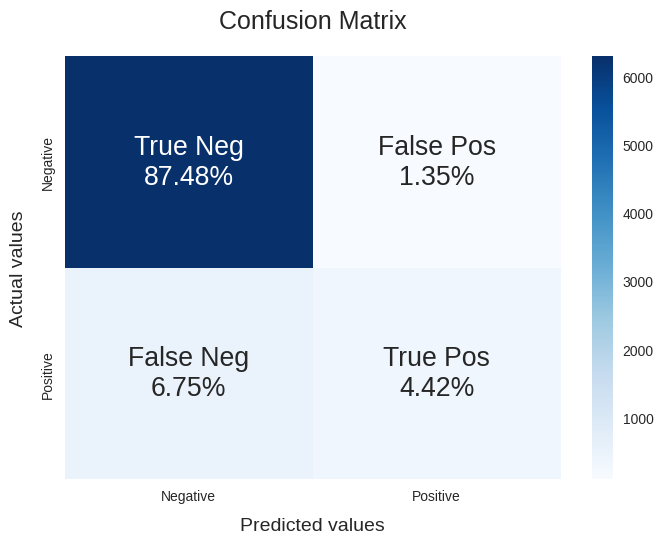

In [ ]:
# Logistic regression without class weight

logistic_regression = LogisticRegression(random_state=50)
logistic_regression.fit(X_w2v_train, y_train)

# Predict on test data
y_pred = logistic_regression.predict(X_w2v_test)


# Print classification report
print(classification_report(y_test, y_pred))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Observations:**

- The model performs well in identifying non-propagandistic articles (negative class) with high precision and recall. This indicates that it is effective in distinguishing non-propagandistic content.

- However, the model's performance in identifying propagandistic articles (positive class) is relatively weaker, with a lower F1-score and recall. This suggests that the model is less effective at correctly identifying propagandistic content.

              precision    recall  f1-score   support

          -1       0.96      0.92      0.94      6394
           1       0.53      0.70      0.60       804

    accuracy                           0.90      7198
   macro avg       0.75      0.81      0.77      7198
weighted avg       0.91      0.90      0.90      7198



Text(0.5, 1.0, 'Confusion Matrix')

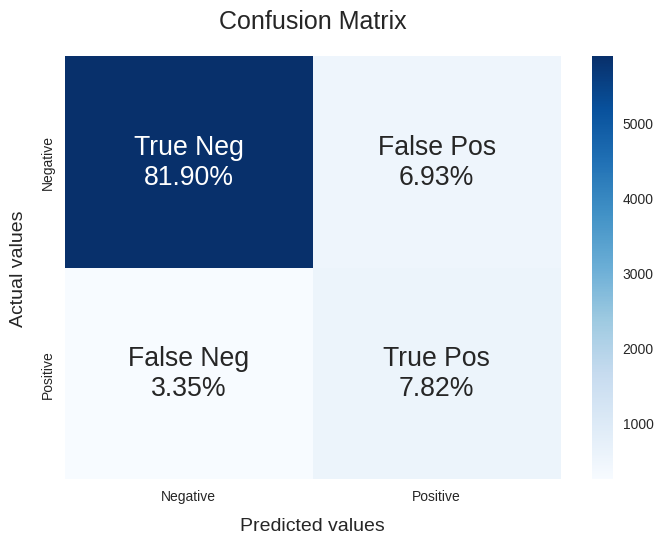

In [ ]:
# Logistic regression with class weight

logistic_regression = LogisticRegression(class_weight={-1:0.2, 1:0.8}, random_state=50)
logistic_regression.fit(X_w2v_train, y_train)

# Predict on test data
y_pred = logistic_regression.predict(X_w2v_test)


# Print classification report
print(classification_report(y_test, y_pred))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Observations:**

- Applying class weights has improved the model's ability to identify propagandistic articles (positive class) compared to the model without class weights. The F1-score and recall for the positive class have increased.

- The model still performs well in identifying non-propagandistic articles (negative class) with high precision and recall.

- These results suggest that applying class weights has improved the model's performance in identifying propagandistic content.

In [ ]:
%%time

# Hyperparameter tuning

# Creating model instance
lr = LogisticRegression(random_state = 50)

# Setting the range for class weights
weights = np.linspace(0.0, 0.99, 10)

# specifying all hyperparameters with possible values
param= {'C': [0.1, 0.5, 1, 10, 15, 20], 'penalty': ['l1', 'l2'], "class_weight":[{-1:x , 1:1.0 -x} for x in weights]}

# Create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 50)

# Hyperparameter tuning using Gridsearch
model= GridSearchCV(estimator= lr, param_grid=param, scoring="f1", cv = folds, return_train_score=True)

#train model to learn relationships between x and y
model.fit(X_w2v_train, y_train)

CPU times: user 8min 4s, sys: 1min 23s, total: 9min 27s
Wall time: 5min 42s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=50, shuffle=True),
             estimator=LogisticRegression(random_state=50),
             param_grid={'C': [0.1, 0.5, 1, 10, 15, 20],
                         'class_weight': [{-1: 0.0, 1: 1.0},
                                          {-1: 0.11, 1: 0.89},
                                          {-1: 0.22, 1: 0.78},
                                          {-1: 0.33, 1: 0.6699999999999999},
                                          {-1: 0.44, 1: 0.56},
                                          {-1: 0.55, 1: 0.44999999999999996},
                                          {-1: 0.66, 1: 0.33999999999999997},
                                          {-1: 0.77, 1: 0.22999999999999998},
                                          {-1: 0.88, 1: 0.12},
                                          {-1: 0.99, 1: 0.010000000000000009}],
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1')

In [ ]:
# printing best hyperparameters

print("Best F1 score: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best F1 score:  0.6582227256834803
Best hyperparameters:  {'C': 20, 'class_weight': {-1: 0.33, 1: 0.6699999999999999}, 'penalty': 'l2'}


In [ ]:
# Building model again with best params

lr_best = LogisticRegression(class_weight = {-1: 0.33, 1: 0.67}, C = 20, penalty = "l2", random_state = 50)

lr_best.fit(X_w2v_train, y_train)

LogisticRegression(C=20, class_weight={-1: 0.33, 1: 0.67}, random_state=50)

Confusion Matrix

[[6121  273]
 [ 294  510]]


Classification Report

              precision    recall  f1-score   support

          -1       0.95      0.96      0.96      6394
           1       0.65      0.63      0.64       804

    accuracy                           0.92      7198
   macro avg       0.80      0.80      0.80      7198
weighted avg       0.92      0.92      0.92      7198


ROC AUC Score: 0.7958160402242774


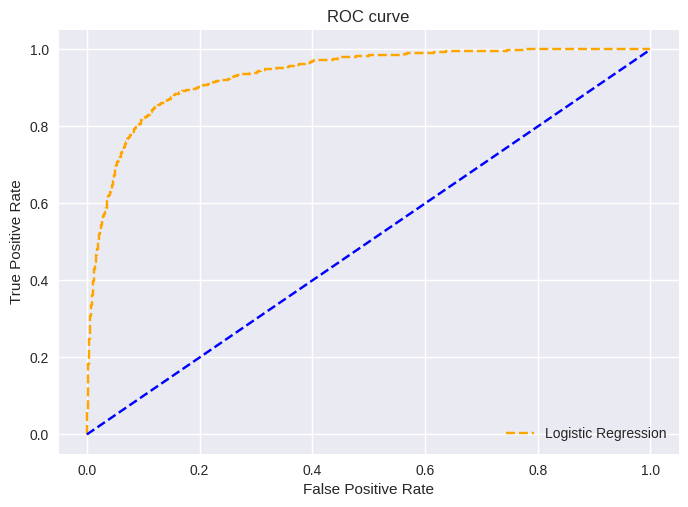

In [ ]:
# Evaluating the model on Training data

# Predicting the labels for train data
y_pred = lr_best.predict(X_w2v_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Get probabilities
y_pred_proba = lr_best.predict_proba(X_w2v_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualize the ROC curve
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

**Observations:**


- The ROC AUC score is 0.80, indicating that the model has a good ability to discriminate between the two classes.

- These results suggest that the hyperparameter-tuned logistic regression model with 'Word2Vec Google News Vector' embedding performs well on the training data, with high accuracy and good balance between precision and recall for both classes. The ROC AUC score also indicates good discriminatory power.

In [ ]:
# Checking validation data

valid_data.head()

,text_preprocessed,propaganda_label
0,"convened examine cause civil unrest black communities, presidential commission issued report stark conclusion: america moving towards two societies, ""one black, one white — separate unequal."" fifty year historic kerner commission identified ""white racism"" key cause ""pervasive discrimination employment, education housing,"" progress african american fare comparison white come homeownership, unemployment incarceration, according report economic policy institute released monday. cases, african american worse today civil right movement culminated law barring housing voter discrimination well ra...",-1
1,"discriminating someone basis sexual orientation prohibited federal civil right law, federal appeal court ruled monday sided gay skydiving instructor fired job discussing sexuality client. decision u.s. court appeal 2nd circuit offer expanded protection lgbt people mark significant loss president donald trump justice department, filed brief arguing title vii civil right act cover sexual orientation discrimination. state law still murky, federal circuit part country issued mixed opinions. ruling 2nd circuit, based manhattan, could appealed supreme court. justice department spokesman devin o'...",-1
2,"bill cosby year old daughter, ensa cosby, died massachusetts kidney disease, spokesman comedian said monday. spokesman andrew wyatt immediately offer detail death friday. ""please keep cosby family prayer give peace time,"" said. bill cosby lost another five child year old son, ennis, graduate student columbia university, shot death changing flat tire near freeway ramp los angeles. year old man later convicted sentenced life prison without parole. bill cosby, 80, owns home western massachusetts town shelburne falls. ensa cosby spoke father behalf trial last year charge drugged molested woman...",-1
3,"fast moving, powerful theatrical locomotive “murder orient express” hartford stage march 25, make stop syria, paris snowbound, tree lined landscape between. really want broadway. though character speak host top european accents, patter new york snappy. show’s designer broadway regular — costume designer extraordinaire william ivey long (a natural gig, done recent broadway revival “on twentieth century”), scenic designer beowulf boritt (“come away,” “meteor shower”), lighting designer ken billington (who worked boritt “sunday park george” “act one”), sound designer darron l. west (a regular...",-1
4,"friday. national pizza day. grab life slice. not? connecticut all. footing national pizza lore remains solid ever. hartford, option pie plentiful. new haven, even better — like thin slightly charred. hardest choice, without doubt, go. you’re bold, take tour. half dozen option you’re hartford area: angelina’s hartford. boast biggest slice around. true pizza detective needed investigate claim, likely won’t leave hungry. handout angelina is: prospect ave, hartford, ct angelina is: prospect ave, hartford, ct (handout) couple turn away, you’ve got lena’s first & last pizzaria hartford parkville...",-1


Confusion Matrix

[[4318  232]
 [ 204  371]]


Classification Report

              precision    recall  f1-score   support

          -1       0.95      0.95      0.95      4550
           1       0.62      0.65      0.63       575

    accuracy                           0.91      5125
   macro avg       0.79      0.80      0.79      5125
weighted avg       0.92      0.91      0.92      5125


ROC AUC Score: 0.7971141901576684


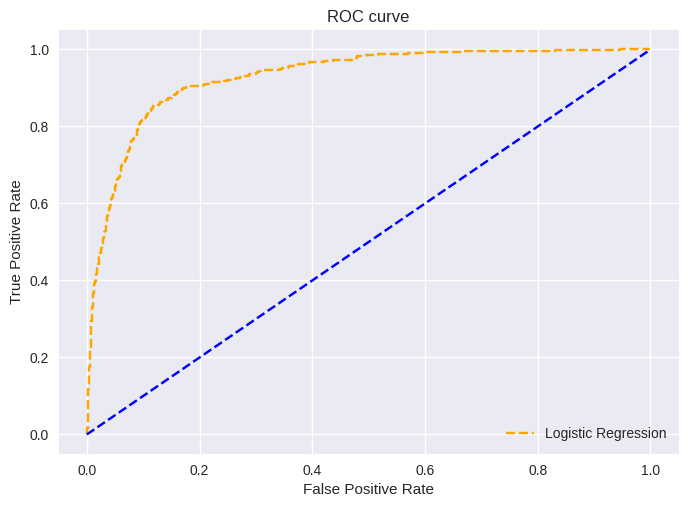

In [ ]:
# Evaluating the model on Validation dataset

# Transforming the validation data into word2vec format using the same vectorizer
X_w2v_test = np.array([vectorize(sentence) for sentence in valid_data.text_preprocessed])


# Changing the label name
y_test = valid_data.propaganda_label

# Predicting the labels for validation data
y_pred = lr_best.predict(X_w2v_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Get probabilities
y_pred_proba = lr_best.predict_proba(X_w2v_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualize the ROC curve
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

**Observations:**


- The ROC AUC score is 0.80, indicating that the model has a good ability to discriminate between the two classes on the validation data.

- These results suggest that the hyperparameter-tuned logistic regression model with 'Word2Vec Google News Vector' embedding also performs well on the validation data, with high accuracy and good balance between precision and recall for both classes. The ROC AUC score is consistent with the model's good discriminatory power.

In [ ]:
# Checking test data

test_data.head()

,text_preprocessed,propaganda_label
0,"eat connecticut teamed end hunger connecticut (ehc) first ever 'culinary corner pub crawl,' jan. 20. crawl featured top blue back square pub restaurants. proceeds benefit ehc program outreach efforts. diner purchased special bracelets, entitled percent discount flora, vinted, india, cook bear, artisan restaurant. participant map stamped venue. jeannette dardenne, co owns eat connecticut, said crawl let community sample food drink west hartford premier restaurant support great cause. dardenne co owner kristen fritz founded social influencer group guide people fun activity supporting local c...",-1
1,"owner old pennsylvania power plant that’s target connecticut anti air pollution lawsuit reached deal sierra club stop burning coal facility peak summer ozone month starting 2023. agreement talen energy, owner high pollution brunner island generating facility, sierra club official halt burning coal power plant may september beginning start phase plan 2023. coal use year old plant ended consent decree, still need court approval. connecticut authority environmental group year demanding federal action clean pollution brunner island steam electric station. cite study showing emission plant drif...",-1
2,"majority owner president donald trump hotel latin america abruptly ordered trump employee property thursday, triggering confrontation trump employee refused leave asked police intervene, according trump organization local news reports. attempt takeover orestes fintiklis — cypriot businessman based miami — marked sharp escalation fintiklis month old effort brand trump international hotel panama replace trump organization manager. fintiklis blame trump brand trump company declining revenue empty rooms. but, far, tactic confined lawsuit angry letters. changed thursday, fintiklis group others ...",-1
3,"connecticut’s likely option using toll help fund transportation project involves “congestion pricing” system charge driver rush hour le peak times, according top state official. state could bring much $750 million year toll revenue using congestion pricing, according transportation commissioner james redeker. warned state commission last month would involve “tolling every interstate limited access [highway] state roads.” way achieve level revenue would put toll state roads, including route 2, 8, merritt parkway, redeker said december hearing commission fiscal stability economic growth. “we...",-1
4,"escaped prisoner jerry mercado back connecticut. year old hartford man escaped carl robinson correctional institution enfield jan. 7. housed northern correctional institution somers, known state’s supermax prison. mercado extradited canton, ga., held since arrest local police jan. 17. initially fought extradition, later waived right. caught, mercado bleached hair eyebrow made effort cover notorious neck tattoo reads: “time wait one.” department correction’s fugitive investigation unit, working concert u.s. marshal fugitive task force connecticut state police, developed intelligence placing...",-1


Confusion Matrix

[[8581  438]
 [ 430  710]]


Classification Report

              precision    recall  f1-score   support

          -1       0.95      0.95      0.95      9019
           1       0.62      0.62      0.62      1140

    accuracy                           0.91     10159
   macro avg       0.79      0.79      0.79     10159
weighted avg       0.91      0.91      0.91     10159


ROC AUC Score: 0.7871214375888718


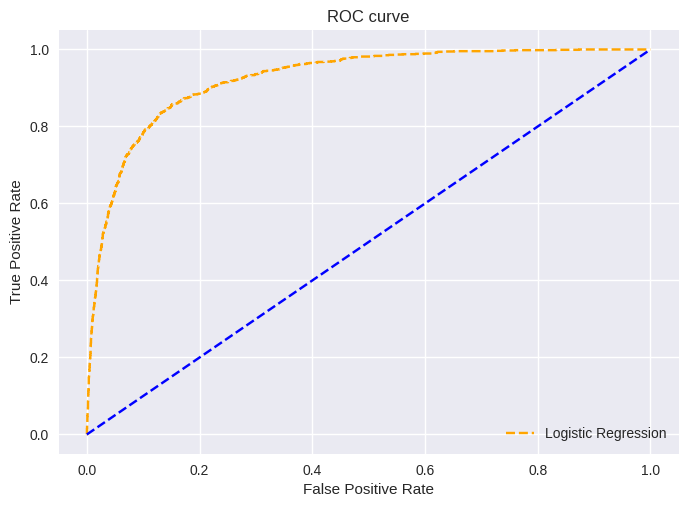

In [ ]:
# Evaluating the model on test dataset

# Transforming the validation data into word2vec format using the same vectorizer
X_w2v_test = np.array([vectorize(sentence) for sentence in test_data.text_preprocessed])

# Changing the label name
y_test = test_data.propaganda_label

# Predicting the labels for validation data
y_pred = lr_best.predict(X_w2v_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Get probabilities
y_pred_proba = lr_best.predict_proba(X_w2v_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualize the ROC curve
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

**Observations:**

- The ROC AUC score is 0.79, indicating that the model has a good ability to discriminate between the two classes on the test data.

- These results suggest that the hyperparameter-tuned logistic regression model with 'Word2Vec Google News Vector' embedding also performs well on the test dataset, with high accuracy and good balance between precision and recall for both classes. The ROC AUC score is consistent with the model's good discriminatory power.

- Overall, the model seems to generalize well to unseen data, as evidenced by its performance on the test dataset.

- Overall, the model seems to generalize well to unseen data, as evidenced by its performance on the test dataset.

### **5. LDA**

In [ ]:
# Selecting the features and the target variables

X = train_data["text_preprocessed"]
y = train_data["propaganda_label"]

In [ ]:
# Train-Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)

In [ ]:
%%time

from sklearn.decomposition import LatentDirichletAllocation

# Creating a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Applying LDA
num_topics = 5    ### Since I got the highest coherence score for number of topics = 5
lda = LatentDirichletAllocation(n_components = num_topics, random_state=50)

X_train_topics = lda.fit_transform(X_train_vec)
X_test_topics = lda.transform(X_test_vec)

# Extracting the topics
topics = lda.components_

CPU times: user 4min 41s, sys: 4.34 s, total: 4min 45s
Wall time: 4min 51s


In [ ]:
for topic_idx, topic in enumerate(topics):

    print(f"Topic {topic_idx}: {', '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-5:]])}")

Topic 0: china, state, year, trump, said
Topic 1: syria, israeli, state, israel, said
Topic 2: police, time, people, year, said
Topic 3: government, minister, korea, north, said
Topic 4: house, state, president, trump, said


Classification Report:
               precision    recall  f1-score   support

          -1       0.89      1.00      0.94      6394
           1       0.00      0.00      0.00       804

    accuracy                           0.89      7198
   macro avg       0.44      0.50      0.47      7198
weighted avg       0.79      0.89      0.84      7198



Text(0.5, 1.0, 'Confusion Matrix')

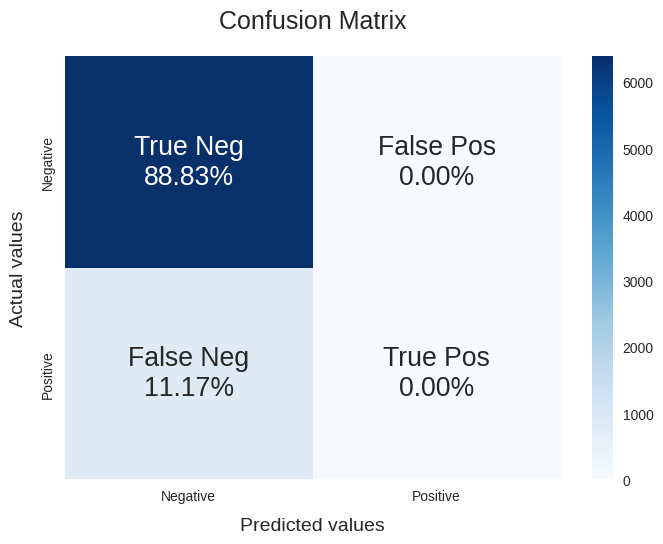

In [ ]:
# Logistic regression without class weight

from scipy.sparse import csr_matrix


# Applying Logistic Regression
logreg_classifier = LogisticRegression(random_state=50)
logreg_classifier.fit(X_train_topics, y_train)
y_pred = logreg_classifier.predict(X_test_topics)

classification_report_result = classification_report(y_test, y_pred)

# Printing the evaluation results
print('Classification Report:\n', classification_report_result)

# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Observations:**

- The F1-score for the negative class (-1) is 0.94, indicating good performance in identifying non-propagandistic articles, with a recall of 1.00.

- The F1-score for the positive class (1) is 0.00, indicating poor performance in identifying propagandistic articles, with a recall of 0.00.

- These results suggest that the model is heavily biased toward predicting the majority class (non-propagandistic articles), resulting in high accuracy for that class but poor performance on the minority class (propagandistic articles). This issue may be due to class imbalance and the limitations of using LDA embeddings for this specific task.

Classification Report:
               precision    recall  f1-score   support

          -1       0.91      0.87      0.89      6394
           1       0.24      0.32      0.27       804

    accuracy                           0.81      7198
   macro avg       0.58      0.60      0.58      7198
weighted avg       0.84      0.81      0.82      7198



Text(0.5, 1.0, 'Confusion Matrix')

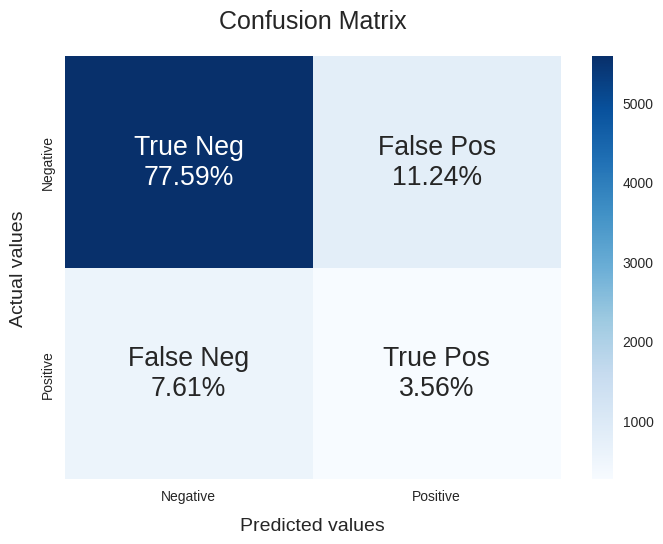

In [ ]:
# Logistic regression with class weight

# Applying Logistic Regression
logreg_classifier = LogisticRegression(class_weight={-1:0.2, 1:0.8}, random_state=50)
logreg_classifier.fit(X_train_topics, y_train)
y_pred = logreg_classifier.predict(X_test_topics)

classification_report_result = classification_report(y_test, y_pred)

# Printing the evaluation results
print('Classification Report:\n', classification_report_result)

# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Observations:**

- The F1-score for the negative class (-1) is 0.89, indicating reasonable performance in identifying non-propagandistic articles, with a recall of 0.87.

- The F1-score for the positive class (1) is 0.27, indicating poor performance in identifying propagandistic articles, with a recall of 0.32.

- These results suggest that while the use of class weights helps balance the model's performance on both classes to some extent, the model still struggles to effectively identify propagandistic articles. It's possible that the limitations of LDA embeddings for this specific task and the class imbalance issue contribute to the model's challenges.

In [ ]:
%%time

# Hyperparameter tuning

# Creating model instance
lr = LogisticRegression(random_state = 50)

# Setting the range for class weights
weights = np.linspace(0.0, 0.99, 10)

# specifying all hyperparameters with possible values
param= {'C': [0.1, 0.5, 1, 10, 15, 20], 'penalty': ['l1', 'l2'], "class_weight":[{-1:x , 1:1.0 -x} for x in weights]}

# Create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 50)

# Hyperparameter tuning using Gridsearch
model= GridSearchCV(estimator= lr, param_grid=param, scoring="f1", cv=folds, return_train_score=True)

#train model to learn relationships between x and y
model.fit(X_train_topics, y_train)

CPU times: user 28 s, sys: 20 s, total: 48 s
Wall time: 29.3 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=50, shuffle=True),
             estimator=LogisticRegression(random_state=50),
             param_grid={'C': [0.1, 0.5, 1, 10, 15, 20],
                         'class_weight': [{-1: 0.0, 1: 1.0},
                                          {-1: 0.11, 1: 0.89},
                                          {-1: 0.22, 1: 0.78},
                                          {-1: 0.33, 1: 0.6699999999999999},
                                          {-1: 0.44, 1: 0.56},
                                          {-1: 0.55, 1: 0.44999999999999996},
                                          {-1: 0.66, 1: 0.33999999999999997},
                                          {-1: 0.77, 1: 0.22999999999999998},
                                          {-1: 0.88, 1: 0.12},
                                          {-1: 0.99, 1: 0.010000000000000009}],
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1')

In [ ]:
# printing best hyperparameters

print("Best F1 score: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best F1 score:  0.32392786718409694
Best hyperparameters:  {'C': 0.5, 'class_weight': {-1: 0.11, 1: 0.89}, 'penalty': 'l2'}


In [ ]:
# Building model again with best params

lr_best = LogisticRegression(class_weight = {-1: 0.11, 1: 0.89}, C = 0.5, penalty = "l2", random_state = 50)

lr_best.fit(X_train_topics, y_train)

LogisticRegression(C=0.5, class_weight={-1: 0.11, 1: 0.89}, random_state=50)

In [ ]:
# Train data performance

# Predict on test data
y_pred = lr_best.predict(X_test_topics)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.95      0.63      0.76      6394
           1       0.20      0.74      0.32       804

    accuracy                           0.64      7198
   macro avg       0.58      0.69      0.54      7198
weighted avg       0.87      0.64      0.71      7198



Confusion Matrix

[[4038 2356]
 [ 208  596]]


Classification Report

              precision    recall  f1-score   support

          -1       0.95      0.63      0.76      6394
           1       0.20      0.74      0.32       804

    accuracy                           0.64      7198
   macro avg       0.58      0.69      0.54      7198
weighted avg       0.87      0.64      0.71      7198


ROC AUC Score: 0.6864115456499174


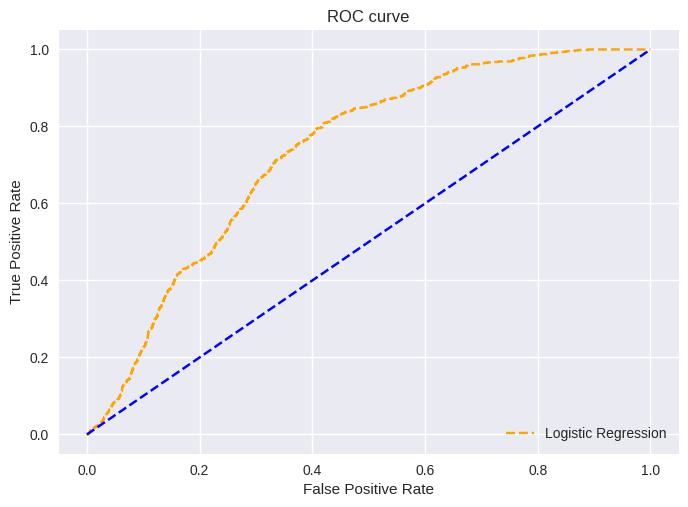

In [ ]:
# Evaluating the model on Training data

# Predicting the labels for train data
y_pred = lr_best.predict(X_test_topics)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Get probabilities
y_pred_proba = lr_best.predict_proba(X_test_topics)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualize the ROC curve
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

**Observations:**

- The F1-score for the negative class (-1) is 0.76, indicating good performance in identifying non-propagandistic articles, with a recall of 0.63.

- The F1-score for the positive class (1) is 0.32, indicating moderate performance in identifying propagandistic articles, with a recall of 0.74.

- The ROC AUC score is 0.69, suggesting that the model's ability to distinguish between the two classes is moderate.

- These results indicate that the hyperparameter-tuned logistic regression model with LDA embeddings performs relatively well in identifying both non-propagandistic and propagandistic articles on the training data. However, there is still room for improvement, especially in terms of precision for the positive class.

In [ ]:
# Checking validation data

valid_data.head()

,text_preprocessed,propaganda_label
0,"convened examine cause civil unrest black communities, presidential commission issued report stark conclusion: america moving towards two societies, ""one black, one white — separate unequal."" fifty year historic kerner commission identified ""white racism"" key cause ""pervasive discrimination employment, education housing,"" progress african american fare comparison white come homeownership, unemployment incarceration, according report economic policy institute released monday. cases, african american worse today civil right movement culminated law barring housing voter discrimination well ra...",-1
1,"discriminating someone basis sexual orientation prohibited federal civil right law, federal appeal court ruled monday sided gay skydiving instructor fired job discussing sexuality client. decision u.s. court appeal 2nd circuit offer expanded protection lgbt people mark significant loss president donald trump justice department, filed brief arguing title vii civil right act cover sexual orientation discrimination. state law still murky, federal circuit part country issued mixed opinions. ruling 2nd circuit, based manhattan, could appealed supreme court. justice department spokesman devin o'...",-1
2,"bill cosby year old daughter, ensa cosby, died massachusetts kidney disease, spokesman comedian said monday. spokesman andrew wyatt immediately offer detail death friday. ""please keep cosby family prayer give peace time,"" said. bill cosby lost another five child year old son, ennis, graduate student columbia university, shot death changing flat tire near freeway ramp los angeles. year old man later convicted sentenced life prison without parole. bill cosby, 80, owns home western massachusetts town shelburne falls. ensa cosby spoke father behalf trial last year charge drugged molested woman...",-1
3,"fast moving, powerful theatrical locomotive “murder orient express” hartford stage march 25, make stop syria, paris snowbound, tree lined landscape between. really want broadway. though character speak host top european accents, patter new york snappy. show’s designer broadway regular — costume designer extraordinaire william ivey long (a natural gig, done recent broadway revival “on twentieth century”), scenic designer beowulf boritt (“come away,” “meteor shower”), lighting designer ken billington (who worked boritt “sunday park george” “act one”), sound designer darron l. west (a regular...",-1
4,"friday. national pizza day. grab life slice. not? connecticut all. footing national pizza lore remains solid ever. hartford, option pie plentiful. new haven, even better — like thin slightly charred. hardest choice, without doubt, go. you’re bold, take tour. half dozen option you’re hartford area: angelina’s hartford. boast biggest slice around. true pizza detective needed investigate claim, likely won’t leave hungry. handout angelina is: prospect ave, hartford, ct angelina is: prospect ave, hartford, ct (handout) couple turn away, you’ve got lena’s first & last pizzaria hartford parkville...",-1


Confusion Matrix

[[2822 1728]
 [ 139  436]]


Classification Report

              precision    recall  f1-score   support

          -1       0.95      0.62      0.75      4550
           1       0.20      0.76      0.32       575

    accuracy                           0.64      5125
   macro avg       0.58      0.69      0.53      5125
weighted avg       0.87      0.64      0.70      5125


ROC AUC Score: 0.6892403248924989


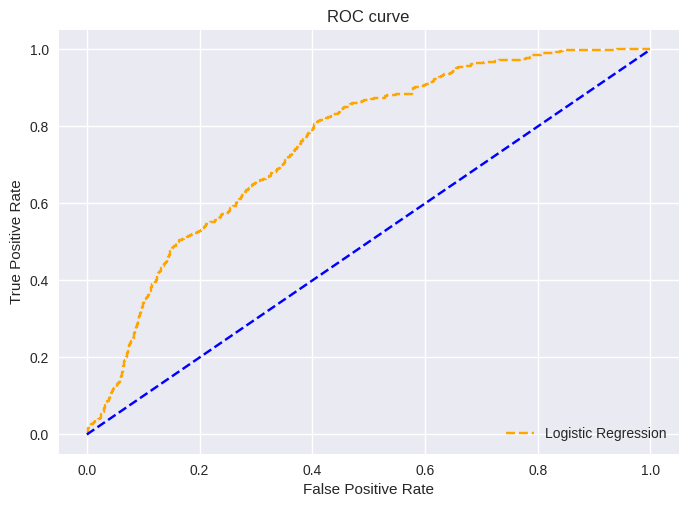

In [ ]:
# Evaluating the model on Validation dataset

# Transforming the validation data into bag-of-words format using the same vectorizer and then applying LDA
X_test_vec = vectorizer.transform(valid_data.text_preprocessed)
X_test_topics = lda.transform(X_test_vec)

# Changing the label name
y_test = valid_data.propaganda_label

# Predicting the labels for validation data
y_pred = lr_best.predict(X_test_topics)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Get probabilities
y_pred_proba = lr_best.predict_proba(X_test_topics)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualize the ROC curve
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

**Observations:**

- The F1-score for the negative class (-1) is 0.75, indicating good performance in identifying non-propagandistic articles, with a recall of 0.62.

- The F1-score for the positive class (1) is 0.32, indicating moderate performance in identifying propagandistic articles, with a recall of 0.76.

- The ROC AUC score is 0.69, suggesting that the model's ability to distinguish between the two classes is moderate and consistent with the training data.

- These results indicate that the model's performance on the validation dataset is similar to its performance on the training data, which is a positive sign of generalization. However, there is still room for improvement, especially in terms of precision for the positive class.

In [ ]:
# Checking test data

test_data.head()

,text_preprocessed,propaganda_label
0,"eat connecticut teamed end hunger connecticut (ehc) first ever 'culinary corner pub crawl,' jan. 20. crawl featured top blue back square pub restaurants. proceeds benefit ehc program outreach efforts. diner purchased special bracelets, entitled percent discount flora, vinted, india, cook bear, artisan restaurant. participant map stamped venue. jeannette dardenne, co owns eat connecticut, said crawl let community sample food drink west hartford premier restaurant support great cause. dardenne co owner kristen fritz founded social influencer group guide people fun activity supporting local c...",-1
1,"owner old pennsylvania power plant that’s target connecticut anti air pollution lawsuit reached deal sierra club stop burning coal facility peak summer ozone month starting 2023. agreement talen energy, owner high pollution brunner island generating facility, sierra club official halt burning coal power plant may september beginning start phase plan 2023. coal use year old plant ended consent decree, still need court approval. connecticut authority environmental group year demanding federal action clean pollution brunner island steam electric station. cite study showing emission plant drif...",-1
2,"majority owner president donald trump hotel latin america abruptly ordered trump employee property thursday, triggering confrontation trump employee refused leave asked police intervene, according trump organization local news reports. attempt takeover orestes fintiklis — cypriot businessman based miami — marked sharp escalation fintiklis month old effort brand trump international hotel panama replace trump organization manager. fintiklis blame trump brand trump company declining revenue empty rooms. but, far, tactic confined lawsuit angry letters. changed thursday, fintiklis group others ...",-1
3,"connecticut’s likely option using toll help fund transportation project involves “congestion pricing” system charge driver rush hour le peak times, according top state official. state could bring much $750 million year toll revenue using congestion pricing, according transportation commissioner james redeker. warned state commission last month would involve “tolling every interstate limited access [highway] state roads.” way achieve level revenue would put toll state roads, including route 2, 8, merritt parkway, redeker said december hearing commission fiscal stability economic growth. “we...",-1
4,"escaped prisoner jerry mercado back connecticut. year old hartford man escaped carl robinson correctional institution enfield jan. 7. housed northern correctional institution somers, known state’s supermax prison. mercado extradited canton, ga., held since arrest local police jan. 17. initially fought extradition, later waived right. caught, mercado bleached hair eyebrow made effort cover notorious neck tattoo reads: “time wait one.” department correction’s fugitive investigation unit, working concert u.s. marshal fugitive task force connecticut state police, developed intelligence placing...",-1


Confusion Matrix

[[5805 3214]
 [ 253  887]]


Classification Report

              precision    recall  f1-score   support

          -1       0.96      0.64      0.77      9019
           1       0.22      0.78      0.34      1140

    accuracy                           0.66     10159
   macro avg       0.59      0.71      0.55     10159
weighted avg       0.87      0.66      0.72     10159


ROC AUC Score: 0.7108556886728408


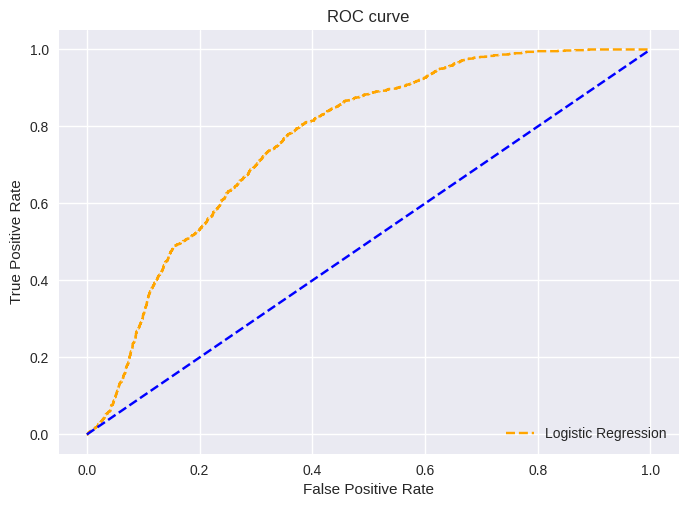

In [ ]:
# Evaluating the model on test dataset

# Transforming the test data into bag-of-words format using the same vectorizer and then applying LDA
X_test_vec = vectorizer.transform(test_data.text_preprocessed)
X_test_topics = lda.transform(X_test_vec)


# Changing the label name
y_test = test_data.propaganda_label

# Predicting the labels for validation data
y_pred = lr_best.predict(X_test_topics)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)

# Get probabilities
y_pred_proba = lr_best.predict_proba(X_test_topics)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

# roc curve for random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Visualize the ROC curve
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

**Observations:**

- The F1-score for the negative class (-1) is 0.77, indicating good performance in identifying non-propagandistic articles, with a recall of 0.64.

- The F1-score for the positive class (1) is 0.34, indicating moderate performance in identifying propagandistic articles, with a recall of 0.78.

- The ROC AUC score is 0.71, suggesting that the model's ability to distinguish between the two classes is moderate and consistent with the performance on the validation data.

- These results indicate that the model generalizes reasonably well to the test dataset and maintains its performance across different datasets. However, there is still room for improvement, especially in terms of precision for the positive class.

#**Summary**

In [89]:
# Using Prettytable for displaying the observations

from prettytable import PrettyTable

table = PrettyTable()

table.field_names = ["S.No","Model", "Vectorizer", "Hyper Parameters", "Accuracy", "F1 - Negative Class(-1)","F1 - Positive Class(1)","AUC Score"]

print(table)

+------+-------+------------+------------------+----------+-------------------------+------------------------+-----------+
| S.No | Model | Vectorizer | Hyper Parameters | Accuracy | F1 - Negative Class(-1) | F1 - Positive Class(1) | AUC Score |
+------+-------+------------+------------------+----------+-------------------------+------------------------+-----------+
+------+-------+------------+------------------+----------+-------------------------+------------------------+-----------+


In [90]:
## Adding rows to the table

table.add_row([1,"Logistic Regression", "Bag Of Words", "'C': 0.1, 'class_weight': {-1: 0.22, 1: 0.78}, 'penalty': 'l2'", 0.95, 0.97, 0.78, 0.87])
table.add_row([2,"Logistic Regression", "TF-IDF", "'C': 15, 'class_weight': {-1: 0.33, 1: 0.66}, 'penalty': 'l2'", 0.96, 0.98, 0.80, 0.87])
table.add_row([3,"Logistic Regression", "Word2Vec", "'C': 20, 'class_weight': {-1: 0.11, 1: 0.89}, 'penalty': 'l2'", 0.52, 0.63, 0.29, 0.68])
table.add_row([4,"Logistic Regression", "Google News Vectors - Word2Vec", "'C': 20, 'class_weight': {-1: 0.11, 1: 0.89}, 'penalty': 'l2'", 0.91, 0.95, 0.62, 0.78])
table.add_row([5,"Logistic Regression", "LDA", "'C': 0.5, 'class_weight': {-1: 0.11, 1: 0.89}, 'penalty': 'l2'", 0.66, 0.77, 0.34, 0.71])

In [91]:
print(table)

+------+---------------------+--------------------------------+----------------------------------------------------------------+----------+-------------------------+------------------------+-----------+
| S.No |        Model        |           Vectorizer           |                        Hyper Parameters                        | Accuracy | F1 - Negative Class(-1) | F1 - Positive Class(1) | AUC Score |
+------+---------------------+--------------------------------+----------------------------------------------------------------+----------+-------------------------+------------------------+-----------+
|  1   | Logistic Regression |          Bag Of Words          | 'C': 0.1, 'class_weight': {-1: 0.22, 1: 0.78}, 'penalty': 'l2' |   0.95   |           0.97          |          0.78          |    0.87   |
|  2   | Logistic Regression |             TF-IDF             | 'C': 15, 'class_weight': {-1: 0.33, 1: 0.66}, 'penalty': 'l2'  |   0.96   |           0.98          |          0.8          

##**Heat Map - Performance of all the Vectorizers**

In [95]:
import pandas as pd
import plotly.express as px

data = {
    "S.No": [1, 2, 3, 4, 5],
    "Model": ["Logistic Regression"] * 5,
    "Vectorizer": ["Bag Of Words", "TF-IDF", "Word2Vec", "Google News Vectors - Word2Vec", "LDA"],
    "Hyper Parameters": [
        "'C': 0.1, 'class_weight': {-1: 0.22, 1: 0.78}, 'penalty': 'l2'",
        "'C': 15, 'class_weight': {-1: 0.33, 1: 0.66}, 'penalty': 'l2'",
        "'C': 20, 'class_weight': {-1: 0.11, 1: 0.89}, 'penalty': 'l2'",
        "'C': 20, 'class_weight': {-1: 0.11, 1: 0.89}, 'penalty': 'l2'",
        "'C': 0.5, 'class_weight': {-1: 0.11, 1: 0.89}, 'penalty': 'l2'"
    ],
    "Accuracy": [0.95, 0.96, 0.52, 0.91, 0.66],
    "F1 - Negative Class(-1)": [0.97, 0.98, 0.63, 0.95, 0.77],
    "F1 - Positive Class(1)": [0.78, 0.80, 0.29, 0.62, 0.34],
    "AUC Score": [0.87, 0.87, 0.68, 0.78, 0.71]
}

df = pd.DataFrame(data)

# Create an annotated heatmap using Plotly
fig = px.imshow(
    df.drop(["S.No", "Model", "Vectorizer", "Hyper Parameters"], axis=1),
    labels=dict(x="Metrics", y="Models", color="Value"),
    x=df.columns[4:],  # Excluding non-numeric columns
    y=df.Vectorizer,
    color_continuous_scale="Tealgrn",
    title="Logistic Regression Performance",
)

# Add text annotations to the heatmap with respective column values
for i in range(len(df.Vectorizer)):
    for j in range(len(df.columns[4:])):
        value = df.iloc[i, j + 4]  # Use j+4 to access the actual value in the DataFrame
        fig.add_annotation(
            text=str(value),
            x=df.columns[4:][j],
            y=df.Vectorizer.iloc[i],
            showarrow=False,
            font=dict(color="white"),  # Font color for text annotations
        )

fig.update_layout(
    xaxis_title="Metrics",
    yaxis_title="Vectorizer",
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    autosize=False,
    width=1200,  # Adjust the width as needed
    height=800,  # Adjust the height as needed
)

fig.show()


###**Animated bubble plot showing ROC scores**

In [96]:
import plotly.express as px
import pandas as pd

data = {
    "Model": ["Logistic Regression", "Logistic Regression", "Logistic Regression", "Logistic Regression", "Logistic Regression"],
    "Vectorizer": ["Bag Of Words", "TF-IDF", "Word2Vec", "Google News Vectors - Word2Vec", "LDA"],
    "ROC Score": [0.87, 0.87, 0.68, 0.78, 0.71],
    "Hyper Parameters": ["'C': 0.1, 'class_weight': {-1: 0.22, 1: 0.78}, 'penalty': 'l2'",
                         "'C': 15, 'class_weight': {-1: 0.33, 1: 0.66}, 'penalty': 'l2'",
                         "'C': 20, 'class_weight': {-1: 0.11, 1: 0.89}, 'penalty': 'l2'",
                         "'C': 20, 'class_weight': {-1: 0.11, 1: 0.89}, 'penalty': 'l2'",
                         "'C': 0.5, 'class_weight': {-1: 0.11, 1: 0.89}, 'penalty': 'l2'"]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create the animated bubble plot
fig = px.scatter(df, x="Model", y="ROC Score", animation_frame="Vectorizer",
                 color="Vectorizer", size="ROC Score", text="ROC Score",
                 title="ROC Score vs. Vectorizer (Animated)", labels={"ROC Score": "ROC Score"})

# Customize the appearance of the plot
fig.update_traces(marker=dict(sizemode='diameter'), selector=dict(mode='markers+text'))
fig.update_xaxes(categoryorder='total descending')

# Show the animated bubble plot
fig.show()

###**Line Plot displaying ROC scores**

In [97]:
import plotly.express as px
import pandas as pd

data = {
    "Model": ["Logistic Regression", "Logistic Regression", "Logistic Regression", "Logistic Regression", "Logistic Regression"],
    "Vectorizer": ["Bag Of Words", "TF-IDF", "Word2Vec", "Google News Vectors - Word2Vec", "LDA"],
    "ROC Score": [0.87, 0.87, 0.68, 0.78, 0.71],
    "Hyper Parameters": ["'C': 0.1, 'class_weight': {-1: 0.22, 1: 0.78}, 'penalty': 'l2'",
                         "'C': 15, 'class_weight': {-1: 0.33, 1: 0.66}, 'penalty': 'l2'",
                         "'C': 20, 'class_weight': {-1: 0.11, 1: 0.89}, 'penalty': 'l2'",
                         "'C': 20, 'class_weight': {-1: 0.11, 1: 0.89}, 'penalty': 'l2'",
                         "'C': 0.5, 'class_weight': {-1: 0.11, 1: 0.89}, 'penalty': 'l2'"],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create the line plot
fig = px.line(df, x="Vectorizer", y="ROC Score", color="Model", text="ROC Score",
              title="ROC Score vs. Vectorizer (Lines by Model)",
              labels={"ROC Score": "ROC Score", "Vectorizer": "Vectorizer", "Model": "Model"})

# Customize the text position
fig.update_traces(textposition='top center')

# Show the line plot
fig.show()
